In [1]:
from astropy.io import fits as pyfits
from astropy import units as u

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from glob import glob

import pandas as pd
from matplotlib import image

In [2]:
# function defs
def spectrum(img_data, row_min, row_max):
    return np.flip(np.average(img_data[row_min:row_max,:], axis=0))

def wavelength(pixel, theta, f, delta=9*u.micrometer, d=(1/600)*(u.millimeter), psi=6.35*u.degree ):
    x1 = d*np.cos(psi)
    x2 = np.sin(theta) + np.sin(theta + (delta*(pixel-381)/f).to(u.rad, equivalencies=u.dimensionless_angles()))
    return x1*x2

#only calculate f once for all frames
def f(p1, p2, lambda1, lambda2, d=(1/600)*(u.millimeter), delta=9*u.micrometer, psi=6.35*u.degree):
    
    lambda1 = lambda1*u.angstrom ; lambda1 = lambda1.to(u.micrometer)
    lambda2 = lambda2*u.angstrom ; lambda2 = lambda2.to(u.micrometer) 
    
    #first, determine theta
    theta = thetai(381, p1, p2, lambda1, lambda2) 
    
    return ((p2-p1)/(lambda2-lambda1))*d*delta*np.cos(theta)*np.cos(psi)

def thetai(p, p1, p2, lambda1, lambda2, d=(1/600)*(u.millimeter), psi=6.35*u.degree):
    lambdap = ((p-p1)*lambda2 - (p-p2)*lambda1)/(p2-p1)
#     print(np.arcsin(lambdap/(2*d*np.cos(psi))))
    return np.arcsin(lambdap/(2*d*np.cos(psi)))

def get_theta(p1, p2, lambda1, lambda2, d=(1/600)*(u.millimeter), delta=9*u.micrometer, psi=6.35*u.degree):
    
    lambda1 = lambda1*u.angstrom ; lambda1 = lambda1.to(u.micrometer)
    lambda2 = lambda2*u.angstrom ; lambda2 = lambda2.to(u.micrometer) 
    
    #first, determine theta
    theta = thetai(381, p1, p2, lambda1, lambda2) 
    
    return theta




def wavelength2(p, p1, p2, lambda1, lambda2):
    lambdap = ((p-p1)*lambda2 - (p-p2)*lambda1)/(p2-p1)
    return lambdap

def theta_i(p1, lambda1, f, d=(1/600)*(u.millimeter), delta=9*u.micrometer, psi=6.35*u.degree):
    lambda1 = lambda1*u.angstrom ; lambda1 = lambda1.to(u.micrometer)
    f = f.to(u.micrometer)
    p1prime = ((delta / f) * (p1 - 381)).to(u.rad, equivalencies=u.dimensionless_angles())
    return np.arcsin(lambda1/(2*d*np.cos(psi)*np.cos(p1prime))) - (p1prime / 2.)

def get_model(model_filename):
    model_obj = pyfits.open(model_filename)
    model=model_obj[1].data
    model_lambda = 10**(model.field(0))#    datafilename = 'G2_+0.0_Dwarf.fits'
    model_flux = model.field(1)
    return(model_lambda,model_flux)

In [3]:
def print_plot(datfram, setting, data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2):
    sunline = datfram.index    
    fig, ax0 = plt.subplots(figsize = (20,5))
    ax0.plot(data1) 
    ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
    ax0.set_title("Mercury Spectrum %s mm"%setting, fontsize=30)
    plt.savefig('Hgfull%s.pdf'%setting)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(data1) ;
    ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
    ax2.plot(data1) 
    ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
    ax1.set_title("%s Angstroms"%l1, fontsize=20)
    ax2.set_title("%s Angstroms"%l2, fontsize=20)
    ax1.set_xlim(p1-10, p1+10)
    ax1.set_ylim(y_min,height)
    ax2.set_xlim(p2-10, p2+10)
    ax2.set_ylim(y_min,height)
    ax1.legend(fontsize=15)
    ax2.legend(fontsize=15)
    plt.savefig('Hgzoom%s.pdf'%setting)

    fig, ax0 = plt.subplots(figsize=(20, 5))
    fig.tight_layout(pad=5)
    ax0.set_title("Sun Spectrum %s mm"%setting, fontsize=35)
    ax0.plot(data2)
    ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) 
    ax0.vlines(psun1, sun_min, sun_max, label = lam1, colors='salmon')
    ax0.vlines(psun2, sun_min, sun_max, label = lam2, colors='purple')
    ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
    ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
    ax0.legend(fontsize=20)
    plt.savefig('Sunfull%s.pdf'%setting)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    ax1.plot(data2);
    ax1.set_title("%s"%sunline[0], fontsize=25) 
    ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')
    ax2.plot(data2);
    ax2.set_title("%s"%sunline[1], fontsize=25)
    ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')
    ax1.set_xlim(psun1-10, psun1+10)
    ax1.set_ylim(sun_min, sun_max)
    ax2.set_xlim(psun2-10, psun2+10)
    ax2.set_ylim(sun_min, sun_max)
    ax1.legend(fontsize=15)
    ax2.legend(fontsize=15)
    plt.savefig('Sunzoom%s.pdf'%setting)
    plt.show()
    

In [4]:
# making a set out of our images
TestSpectrumHiResFiles = {"Sun" : {4.0 : 'HighResSun4.0mm.00000042.FIT',
                                   4.4 : 'HighResSun4.4mm.00000043.FIT',
                                   4.8 : 'HighResSun4.8mm.00000046.FIT',
                                   5.2 : 'HighResSun5.2mm.00000050.FIT',
                                   5.6 : 'HighResSun5.6mm.00000051.FIT',
                                   6.0 : 'HighResSun6.0mm.00000054.FIT',
                                   6.4 : 'HighResSun6.4mm.00000055.FIT',
                                   6.8 : 'HighResSun6.8mm.00000058.FIT'},                                 
                                   
                                
                                   
                                 
                          "Hg"  : {4.0 : 'HighResHgAr4.0mm.00000041.FIT',
                                   4.4 : 'HighResHgAr4.4mm.00000044.FIT',
                                   4.8 : 'HighResHgAr4.8mm.00000045.FIT',
                                   5.2 : 'HighResHgAr5.2mm.00000049.FIT',
                                   5.6 : 'HighResHgAr5.6mm.00000052.FIT',
                                   6.0 : 'HighResHgAr6.0mm.00000053.FIT',
                                   6.4 : 'HighResHgAr6.4mm.00000056.FIT',
                                   6.8 : 'HighResHgAr6.8mm.00000057.FIT'}}  

Micrometer = [4.0, 4.4, 4.8, 5.2, 5.6, 6.0, 6.4, 6.8]

Hg_hdu = []
Sun_hdu = []
Hg_spectra = []
Sun_spectra = []
for microm in Micrometer:
    Hg_hdu = pyfits.open(TestSpectrumHiResFiles['Hg'][microm])
    Sun_hdu = pyfits.open(TestSpectrumHiResFiles['Sun'][microm])
    Hg_spec_data = Hg_hdu[0].data
    Sun_spec_data = Sun_hdu[0].data
    Hg_spectra.append(spectrum(Hg_spec_data, 250, 260))
    Sun_spectra.append(spectrum(Sun_spec_data, 250, 260))



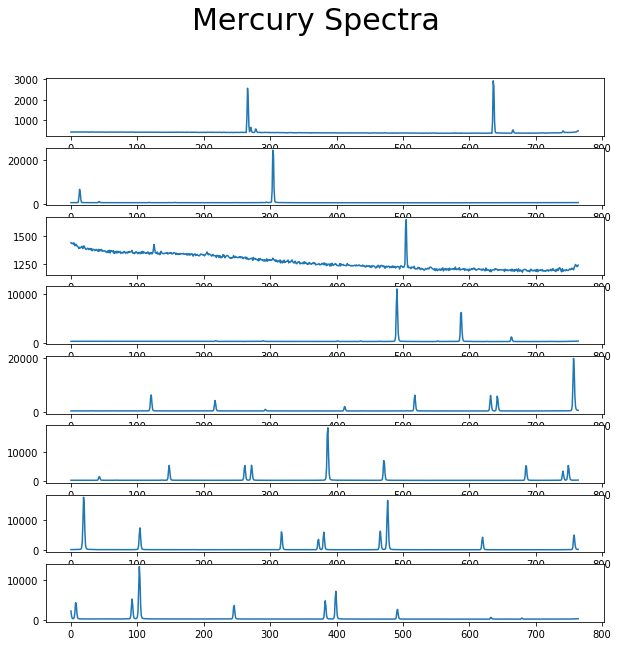

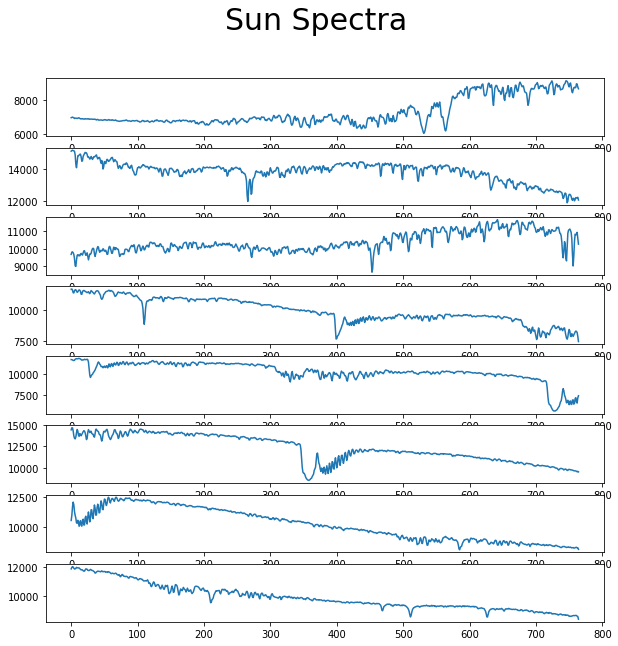

In [5]:
# This prints out all our raw spectrums, use it to make if you want to make sure the spectrum
# you've printed in Calibration is the correct one. 

# comment blocks at a time: control+/

fig, axs = plt.subplots(8, 1, figsize=(10, 10))
axs[0].plot(Hg_spectra[0])
axs[1].plot(Hg_spectra[1])
axs[2].plot(Hg_spectra[2])
axs[3].plot(Hg_spectra[3])
axs[4].plot(Hg_spectra[4])
axs[5].plot(Hg_spectra[5])
axs[6].plot(Hg_spectra[6])
axs[7].plot(Hg_spectra[7])
plt.suptitle("Mercury Spectra", fontsize=30)
plt.savefig("HgSpectra.pdf")

    
fig, axs = plt.subplots(8, 1, figsize=(10, 10))
SunIm1 = axs[0].plot(Sun_spectra[0])
SunIm2 = axs[1].plot(Sun_spectra[1])
SunIm3 = axs[2].plot(Sun_spectra[2])
SunIm4 = axs[3].plot(Sun_spectra[3])
SunIm5 = axs[4].plot(Sun_spectra[4])
SunIm6 = axs[5].plot(Sun_spectra[5])
SunIm7 = axs[6].plot(Sun_spectra[6])
SunIm8 = axs[7].plot(Sun_spectra[7])
plt.suptitle("Sun Spectra", fontsize=30)
plt.savefig("SunSpectra.pdf")



# 4.0
## 3600-4400

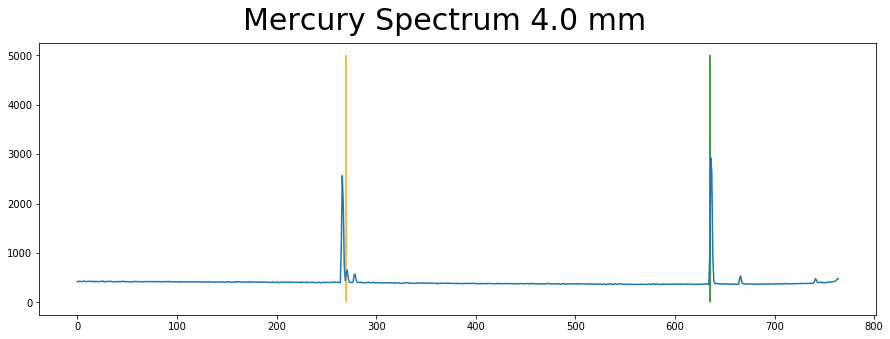

In [6]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 0 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 270 ; p2 = 635
y_min = 0
height = 5000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

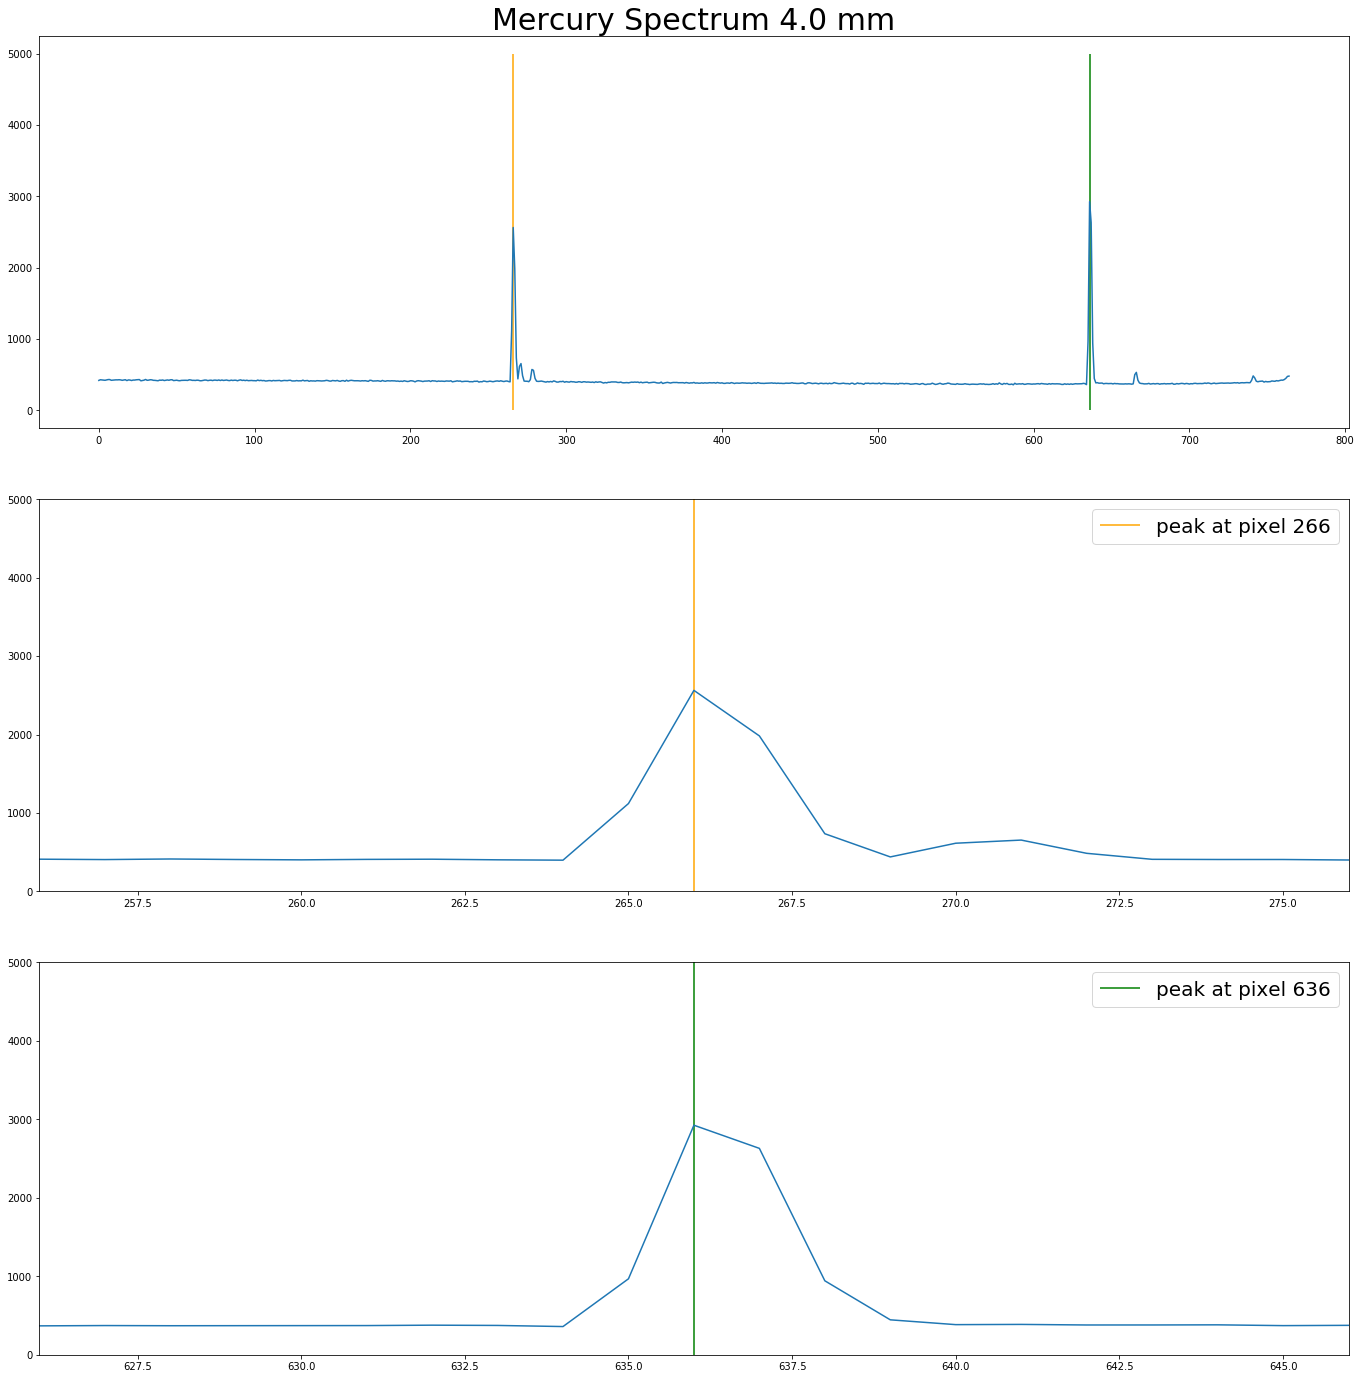

In [7]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
meas = Micrometer[index]

p1 = 266 ; p2 = 636
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [8]:
l1 = 3650.2 

l2 = 4046.6 


#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 138.24552285856265 mm
incedent angle: 0.11414869560756435 rad


Text(0.5, 0.98, 'Sun Spectra')

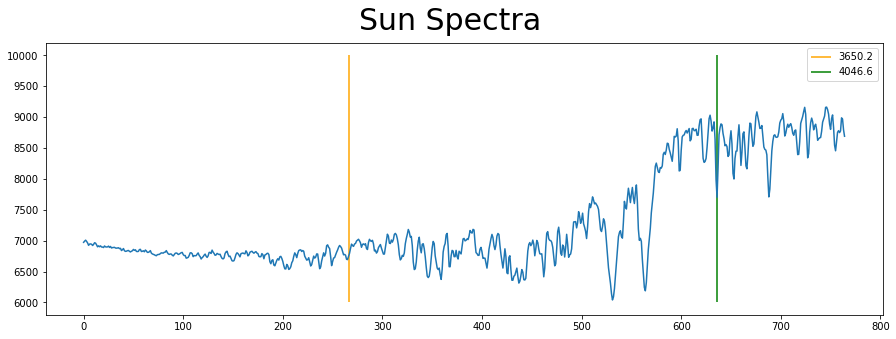

In [9]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=6000
sun_max = 10000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

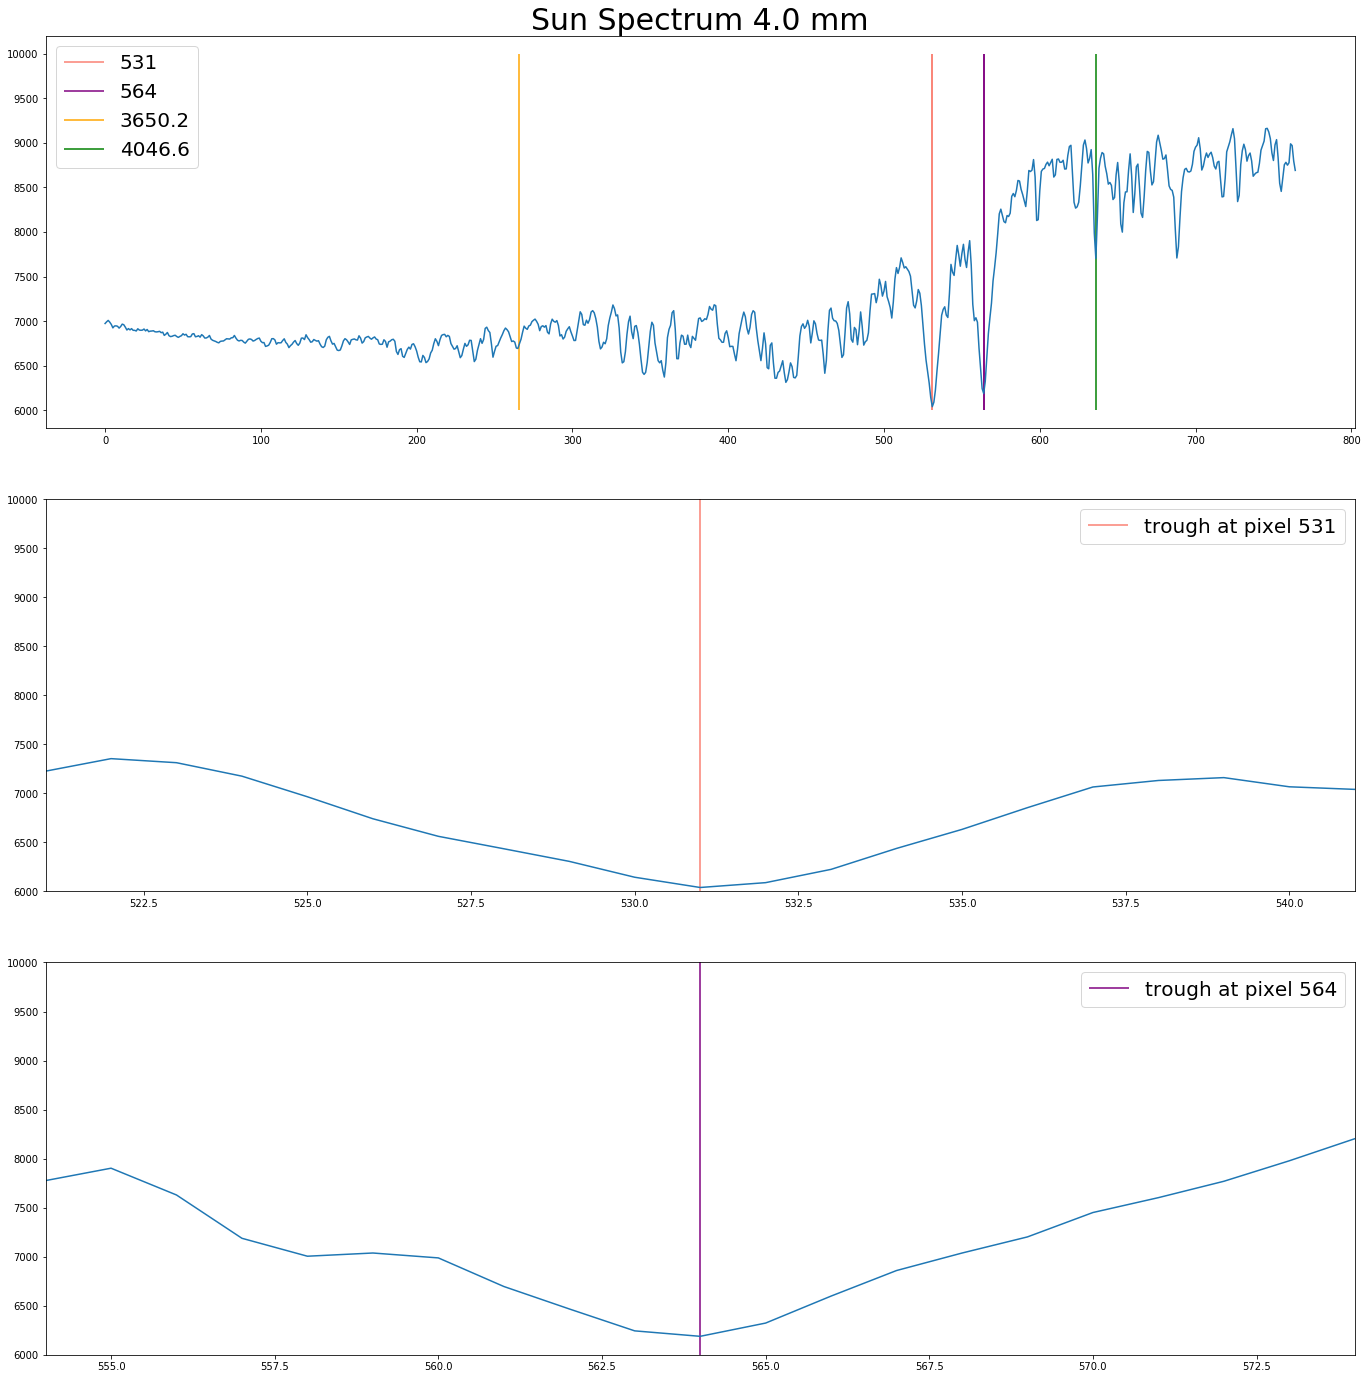

In [10]:
psun1 = 531
psun2 = 564

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [11]:
lam1 = 3933.66 


lam2 = 3968.47


index = ["Ca K", "Ca H"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df = pd.DataFrame(frame, index=index)

display(df)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Ca K           4.0              3934.108108                    3933.66   
Ca H           4.0              3969.462703                    3968.47   

      Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Ca K   0.448108   0.011392         138.245523          0.114149  
Ca H   0.992703   0.025015         138.245523          0.114149

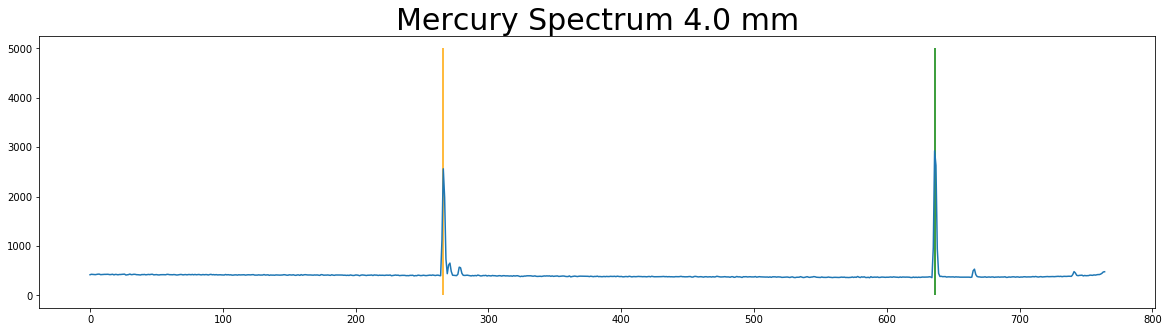

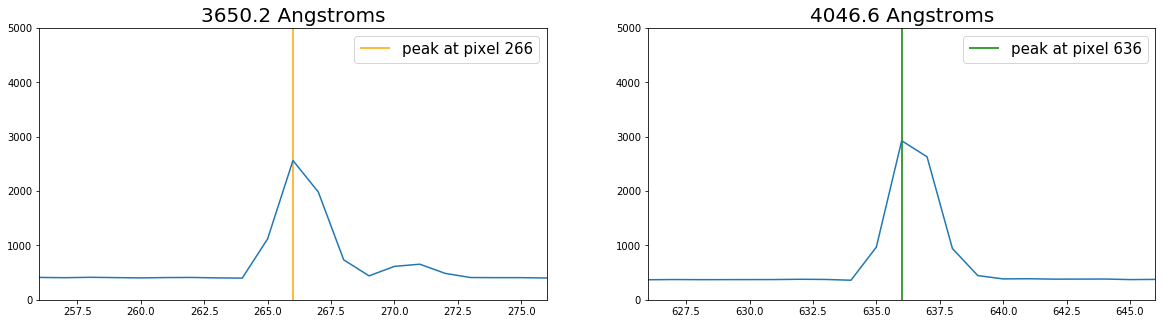

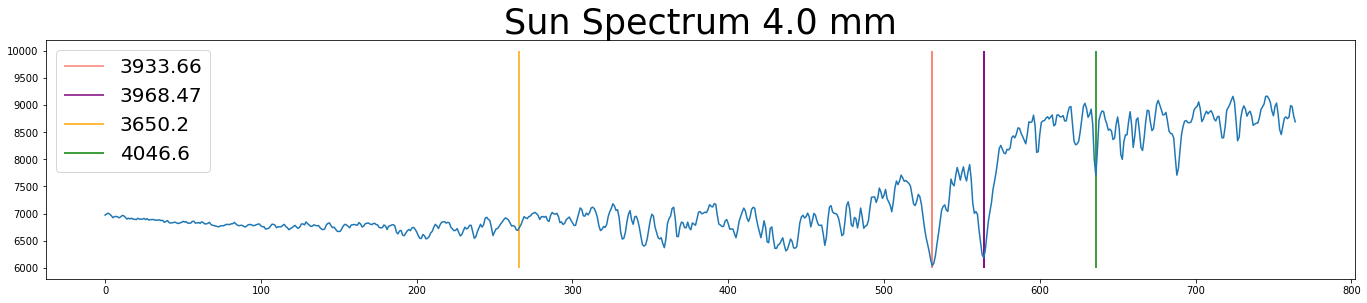

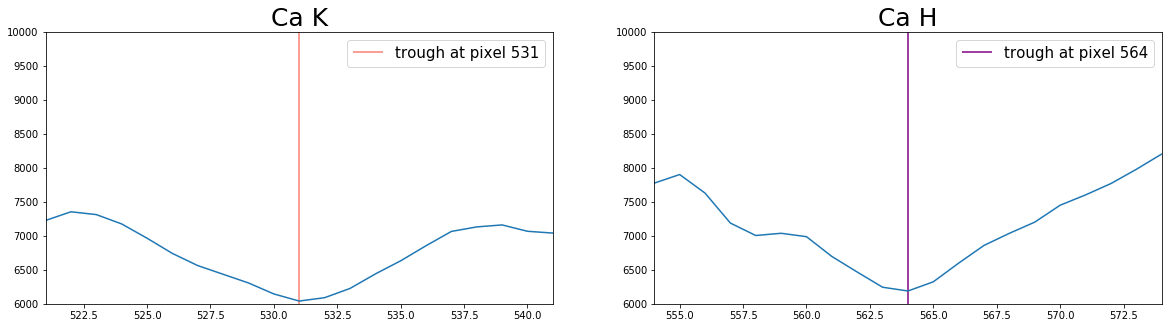

In [12]:
print_plot(df, "4.0", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)


# 4.4

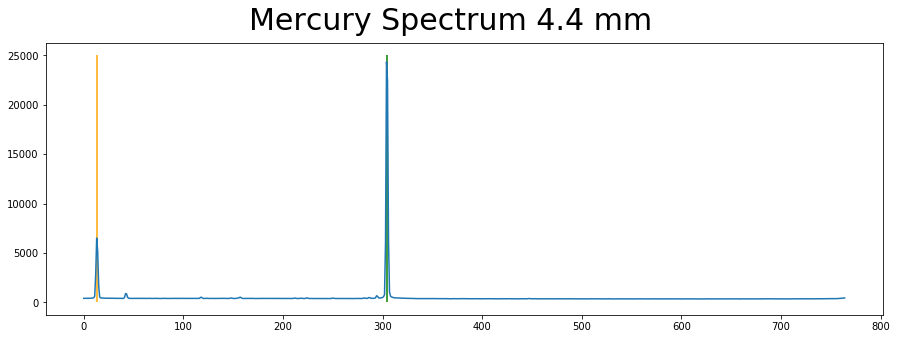

In [68]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 1 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 13 ; p2 = 304
y_min = 0
height = 25000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])




plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

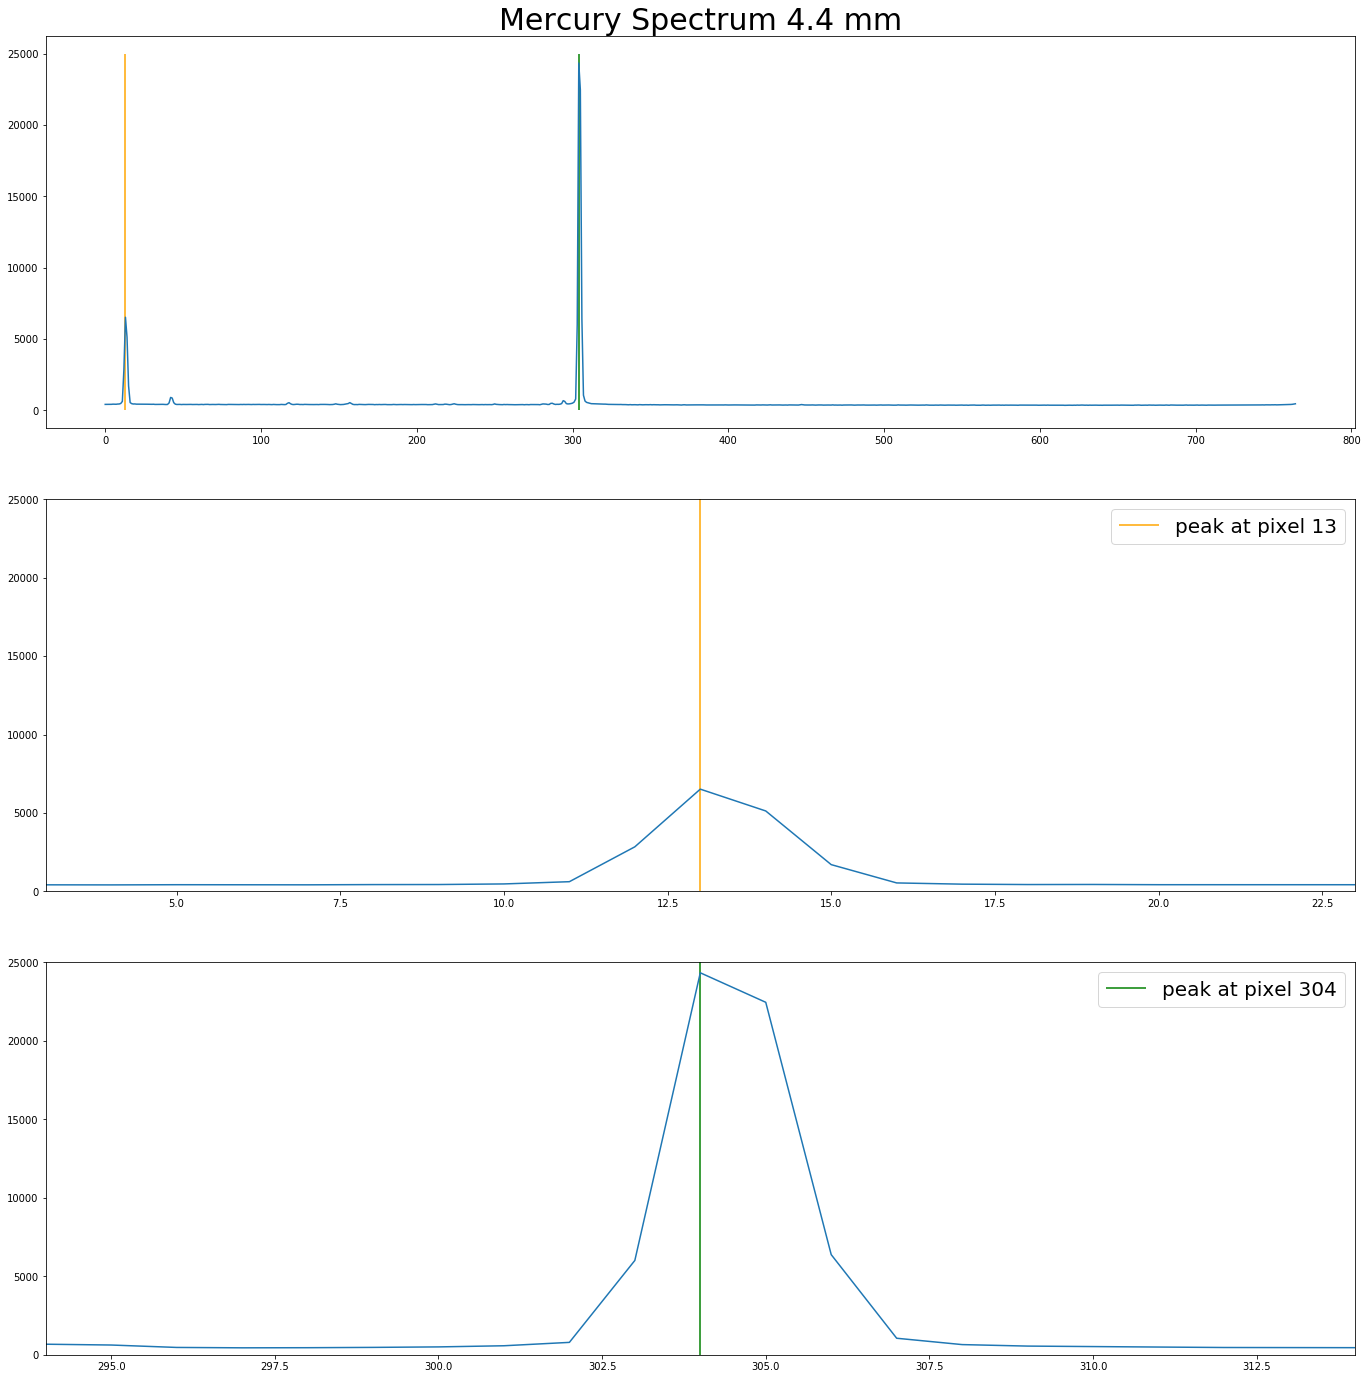

In [69]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 13 ; p2 = 304
meas = Micrometer[index]
y_min = 0
height = 25000

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [70]:

# l1 = 4046.6 

# l2 = 4358.3 #4.4

l1 = 3341.48
l2 = 3650.15



#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 139.65101929475458 mm
incedent angle: 0.11288546982245162 rad


Text(0.5, 0.98, 'Sun Spectra')

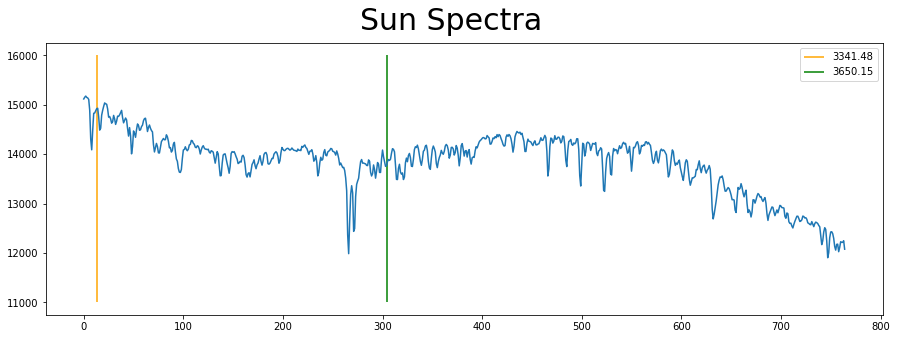

In [71]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=11000
sun_max = 16000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

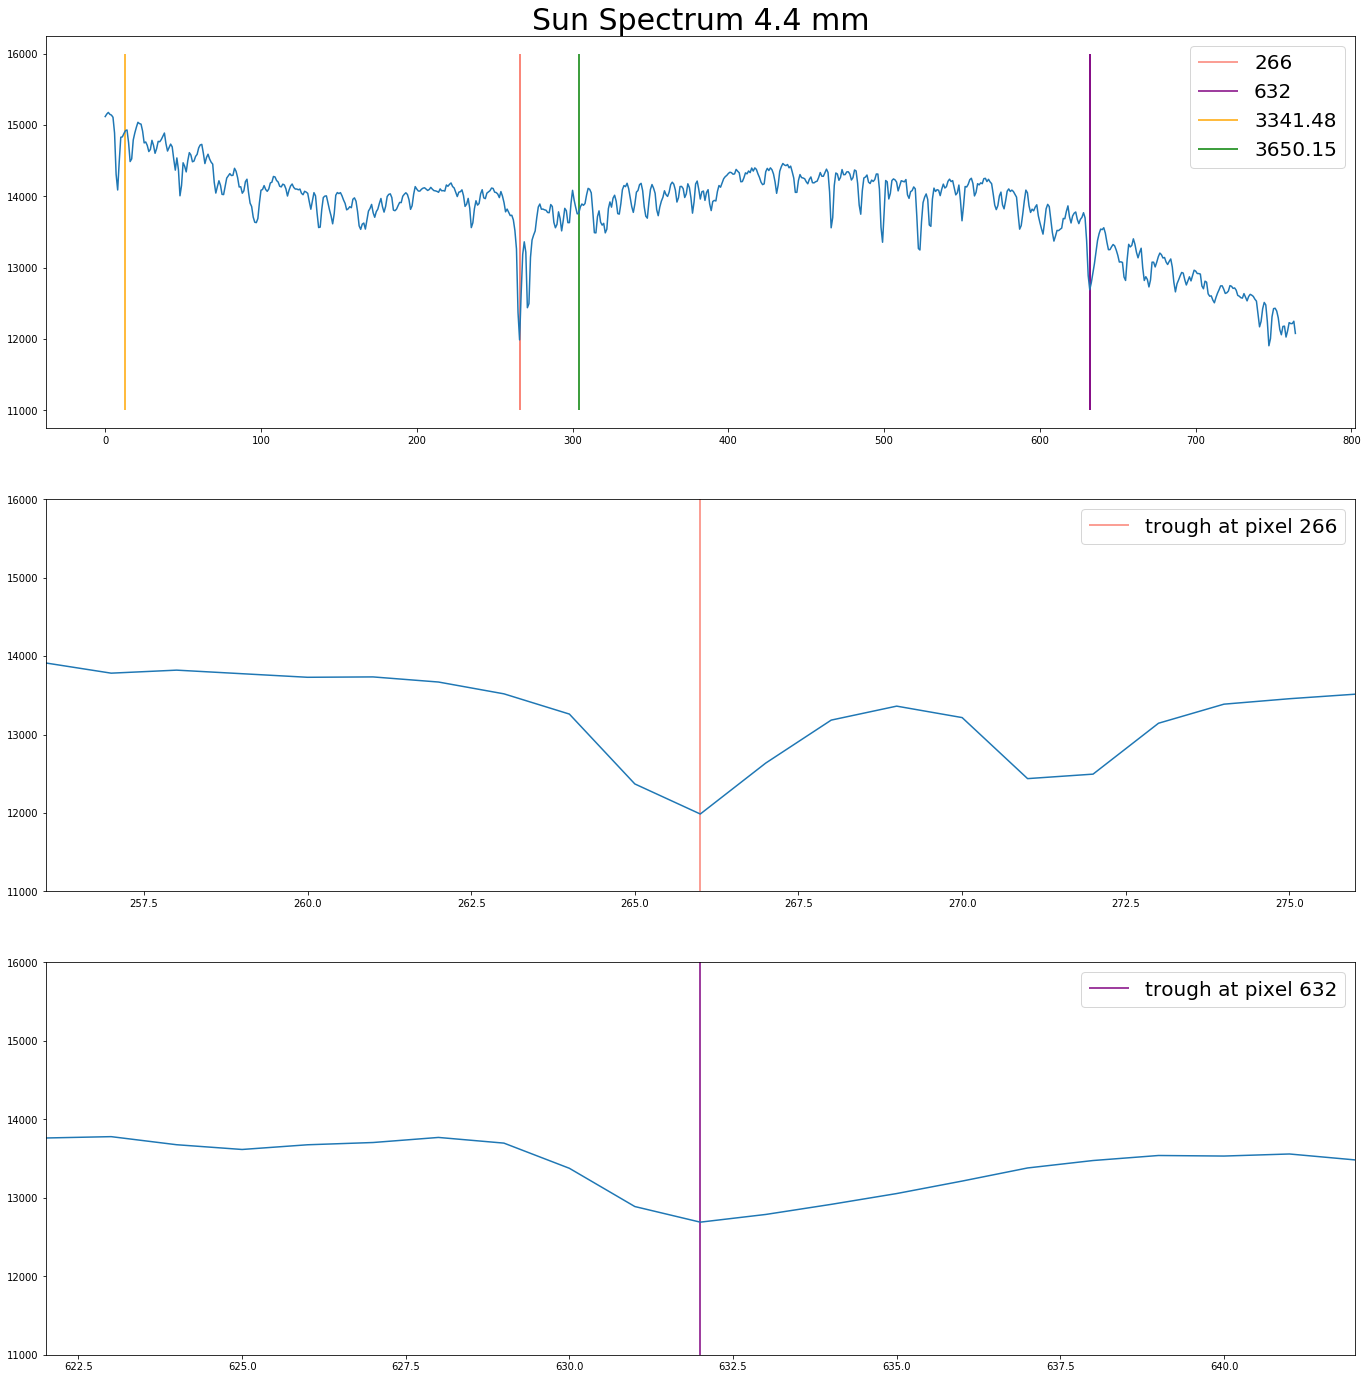

In [74]:
psun1 = 266
# psun2 = 632
psun2 = 

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [80]:
lam1 = 5889.95
# lam2 =5895.92
lam2 = 6276.61
lam2 = 6276.61



index = ["Na D1", "Na D2"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1+2279.5, lsun2+2279.5],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1+2279.5 - lam1, lsun2+2279.5 - lam2],
         u"Error (%)" : [100. * (lsun1+2279.5 - lam1) / lam1, 100. * (lsun2+2279.5 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df2a = pd.DataFrame(frame, index=index)
# df.append(df2)
display(df2a)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Na D1           4.4              5889.342577                    5889.95   
Na D2           4.4              6277.566701                    6276.61   

       Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Na D1  -0.607423  -0.010313         139.651019          0.112885  
Na D2   0.956701   0.015242         139.651019          0.112885

In [76]:
# lam1 = 5889.95
# lam2 =5895.92
lam1 = 3361.12 
lam2 = 3820.44


index = ["Na D1", "Na D2"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1+0, lsun2+0],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1+0 - lam1, lsun2+0 - lam2],
         u"Error (%)" : [100. * (lsun1+0 - lam1) / lam1, 100. * (lsun2+0 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df2b = pd.DataFrame(frame, index=index)
# df.append(df2)
display(df2b)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Na D1           4.4              3609.842577                    3361.12   
Na D2           4.4              3998.066701                    3820.44   

        Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Na D1  248.722577   7.399991         139.651019          0.112885  
Na D2  177.626701   4.649378         139.651019          0.112885

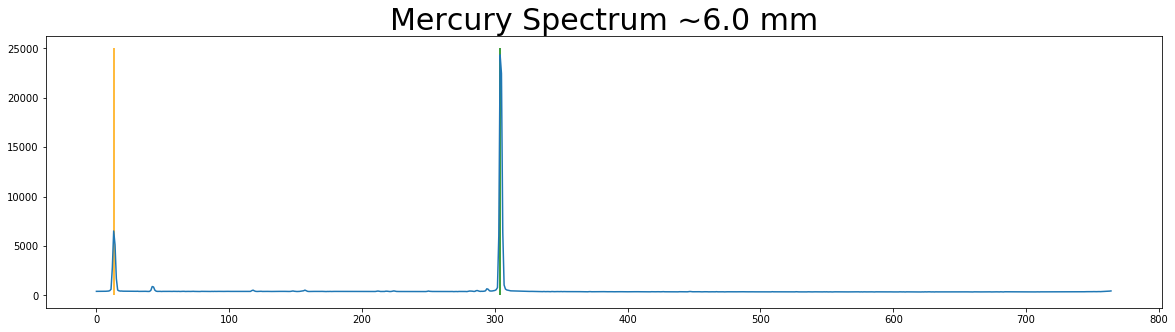

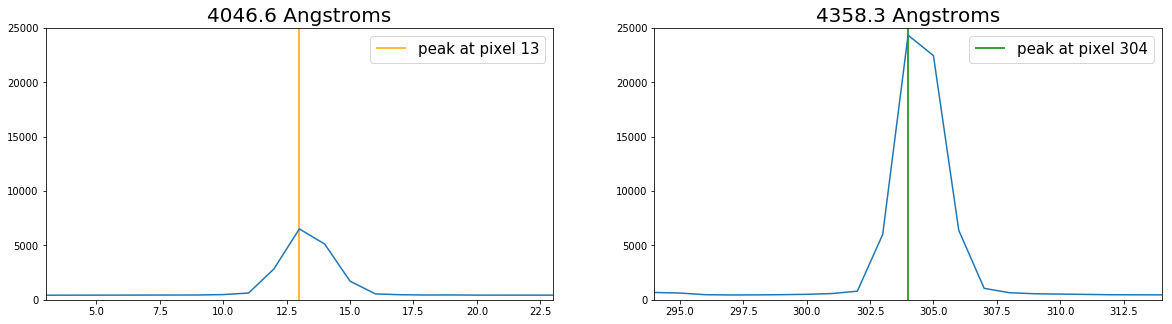

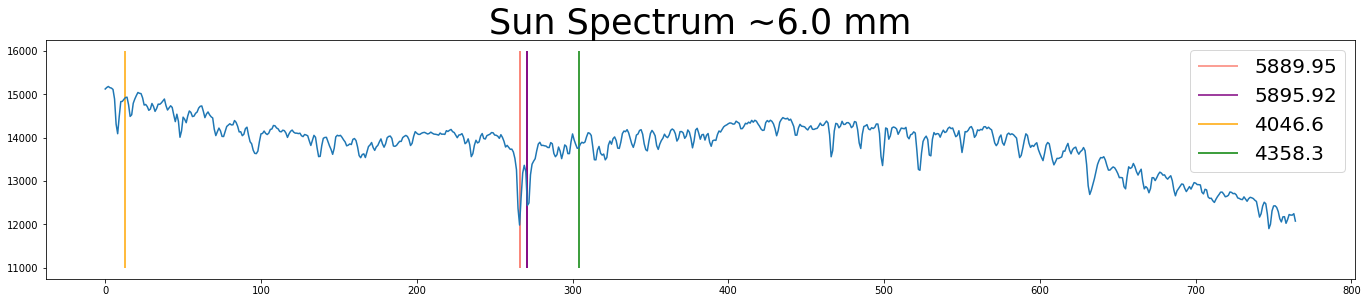

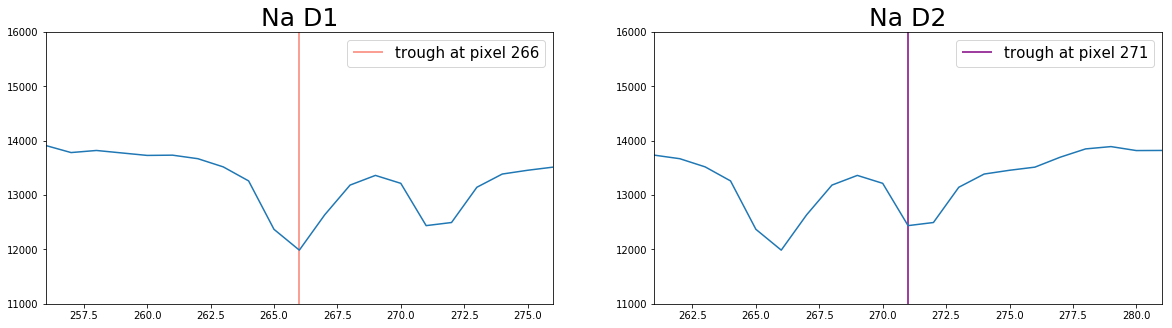

In [21]:
print_plot(df2a, "~6.0", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

# 4.8
##  4400 - 5200

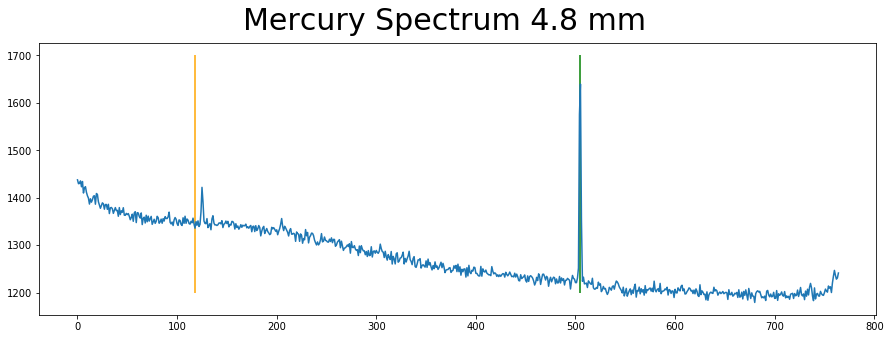

In [22]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 2 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 118 ; p2 = 505
y_min = 1200
height = 1700

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])

plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

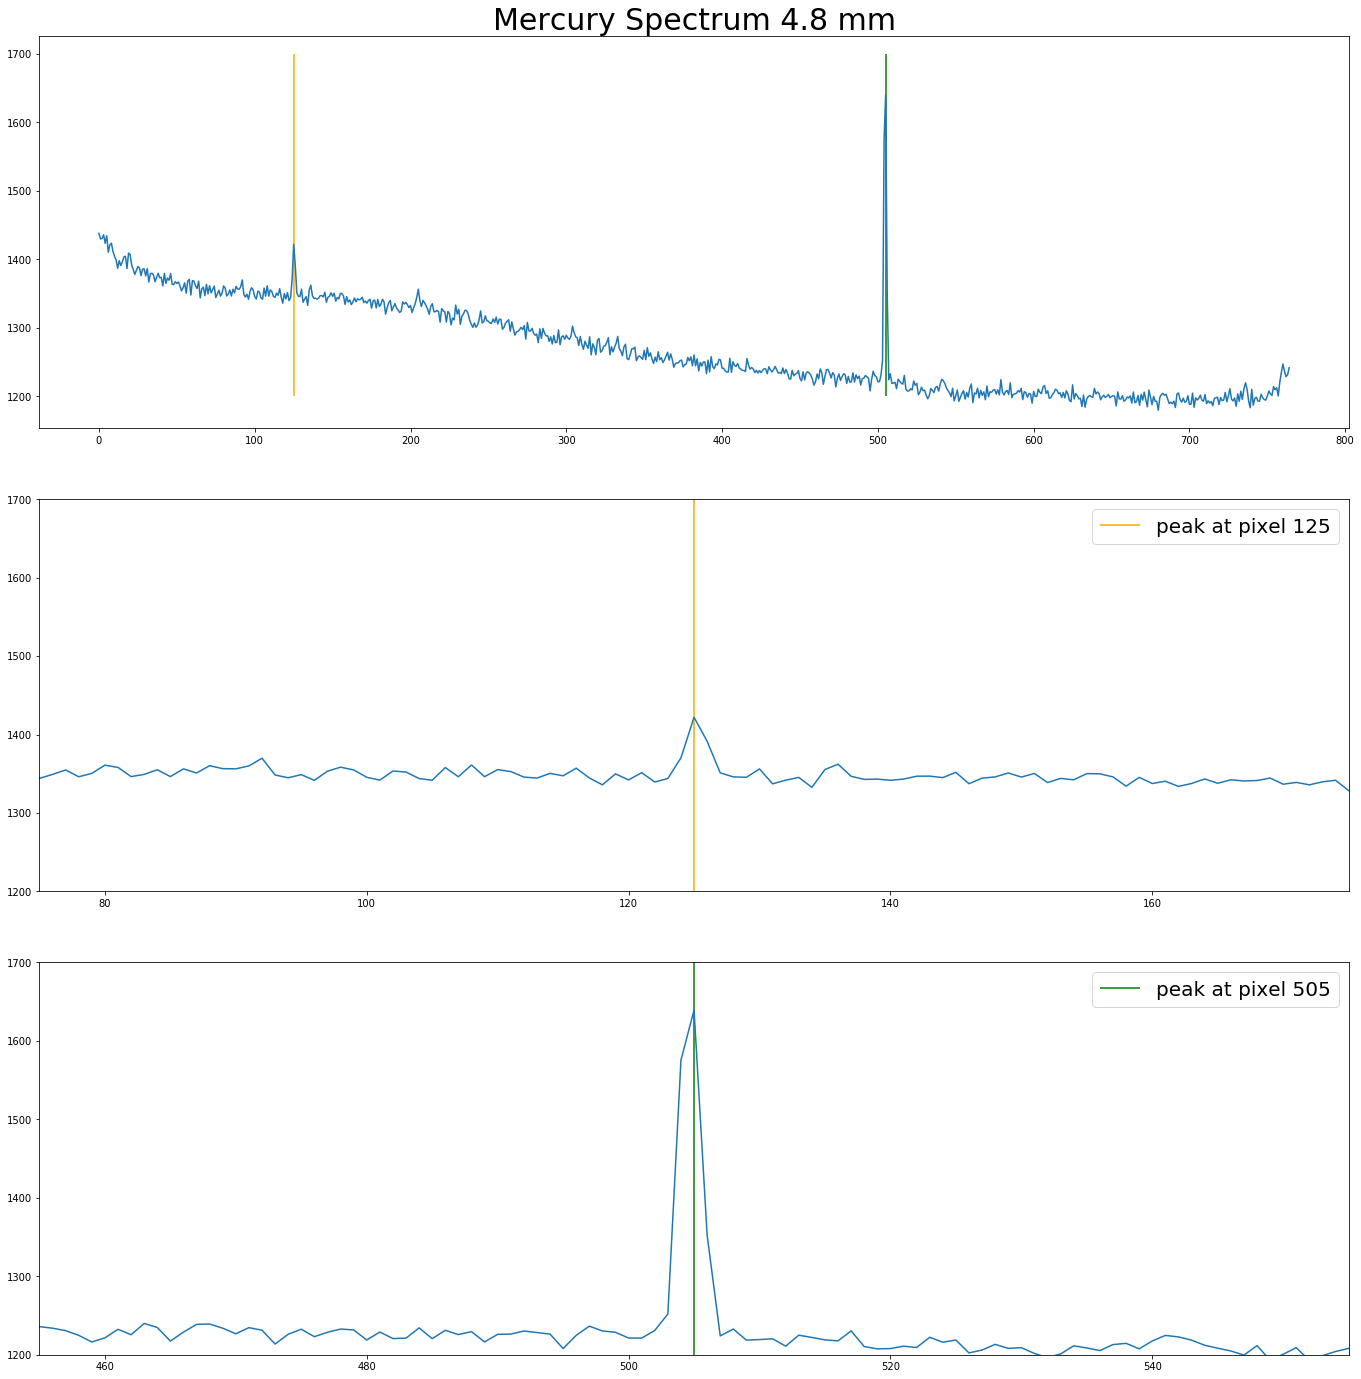

In [23]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 125 ; p2 = 505

meas = Micrometer[index]


fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-50, p1+50)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-50, p2+50)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [24]:
# l1 = 4358.328 #HgI 1000
# l1 = 4426.00 # ArII 130
l1 = 4510.73 # ArI 3
# l1 = 4522.32
# l1 = 4530.55
# l1 = 4545.052
# l1 = 4564.41
# l1 = 4609.57 #HgII 200

# l2 = 4879.864 
# l2 = 4904.752
l2 = 4916.07 # Ar II
# l2 = 4933.209
# l2 = 4965.08


#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 138.29517369893244 mm
incedent angle: 0.14490654526534852 rad


Text(0.5, 0.98, 'Sun Spectra')

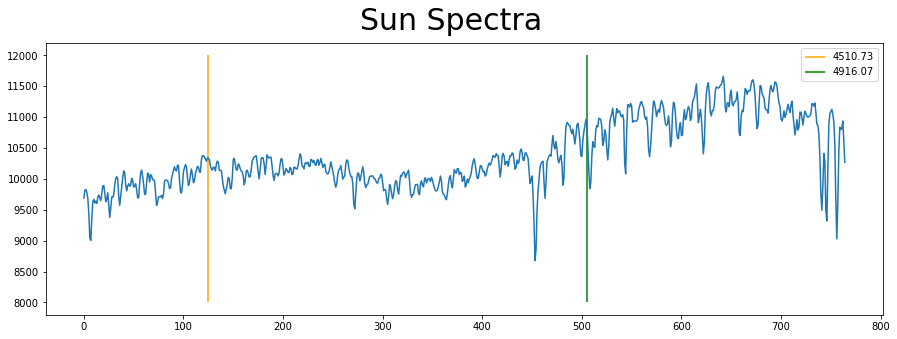

In [25]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=8000
sun_max = 12000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
# plt.vlines(764, sun_min, sun_max, label = '5295', colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

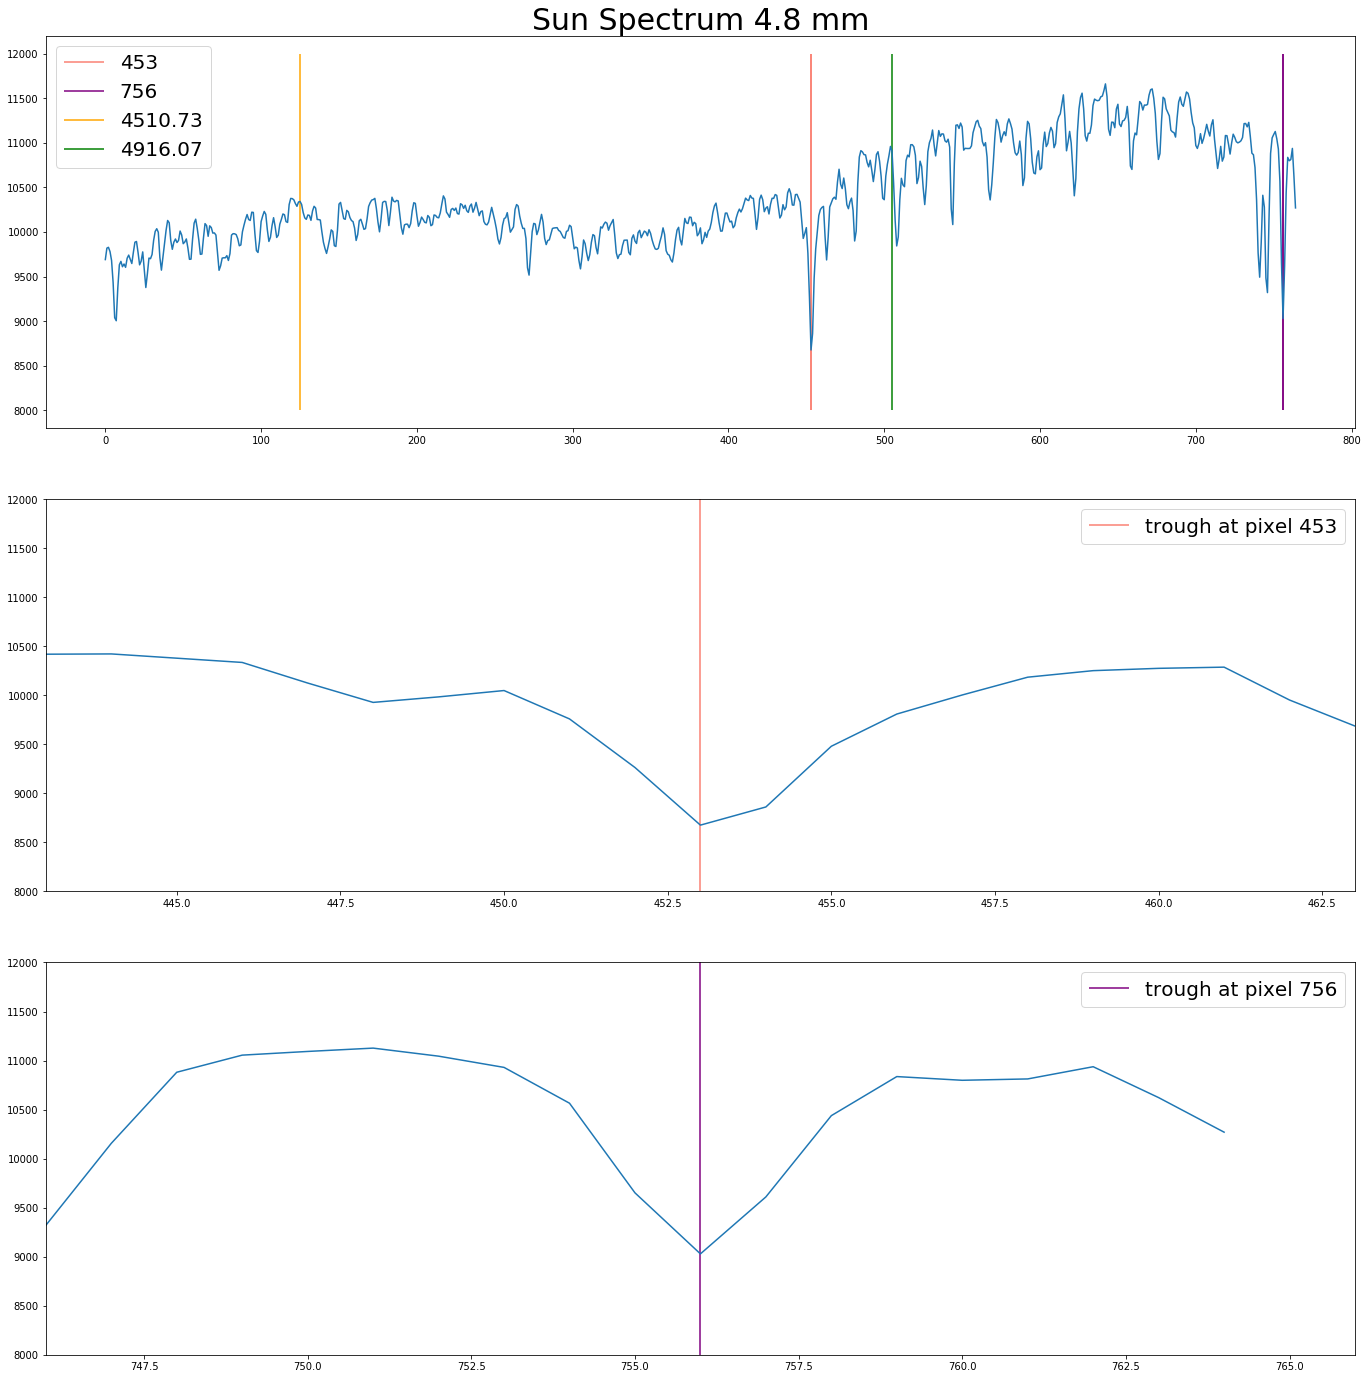

In [26]:
psun1 = 453
psun2 = 756

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [27]:
lam1 = 4861.34 # H-alpha




lam2 = 5183.60 # Mg b1 DONT CHANGE




index = ["H\u03B2 F", "Mg b"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df3 = pd.DataFrame(frame, index=index)
display(df3)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Hβ F           4.8              4860.602421                    4861.34   
Mg b           4.8              5183.807737                    5183.60   

      Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Hβ F  -0.737579  -0.015172         138.295174          0.144907  
Mg b   0.207737   0.004008         138.295174          0.144907

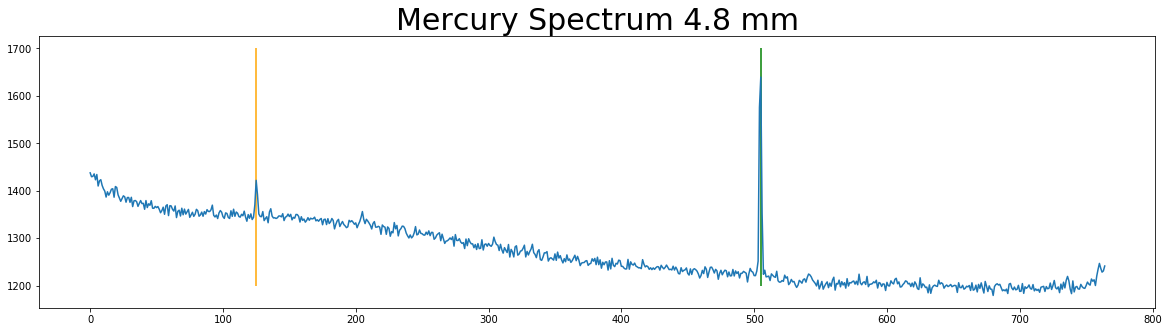

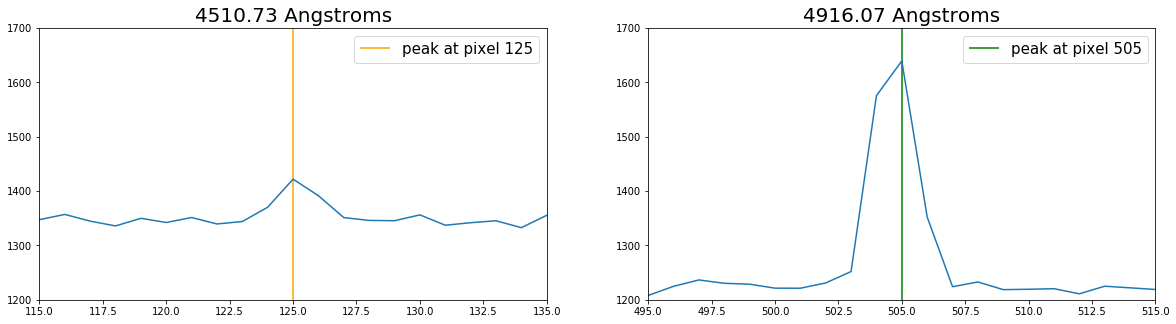

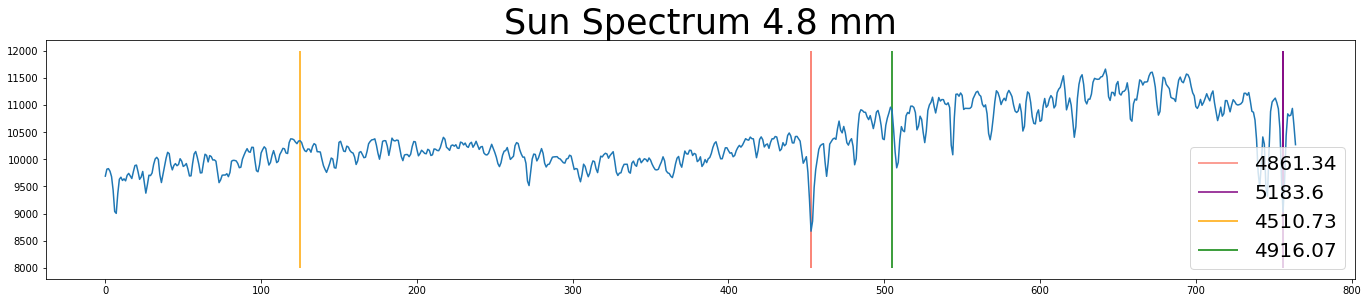

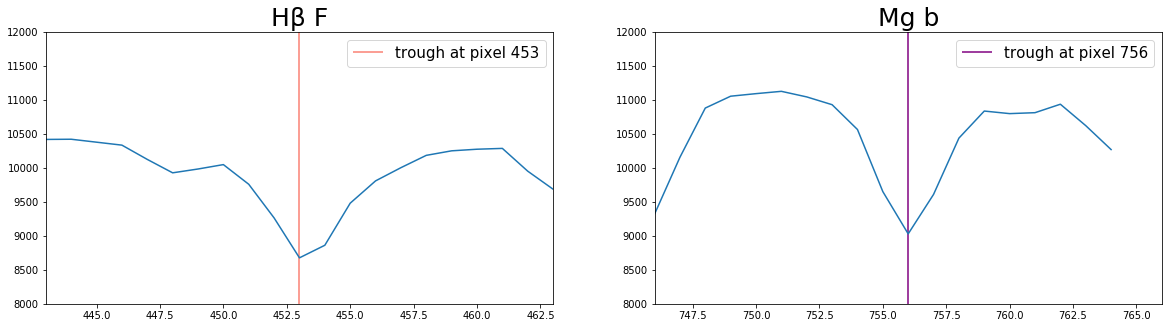

In [28]:
print_plot(df3, "4.8", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

# 5.2
## 4800 - 5600

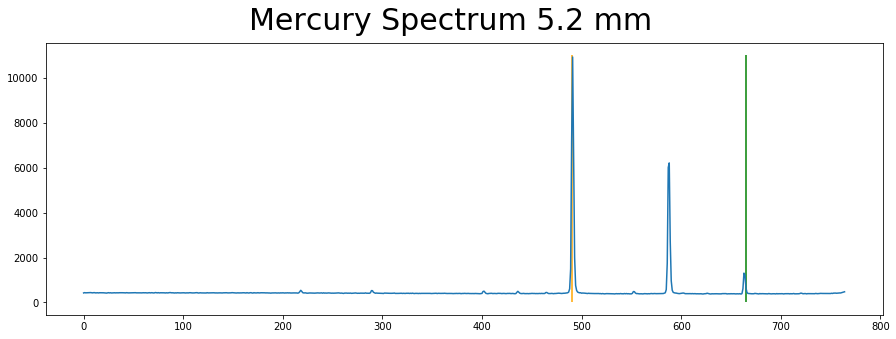

In [29]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 3 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 490 ; p2 = 665
y_min = 0
height = 11000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])




plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

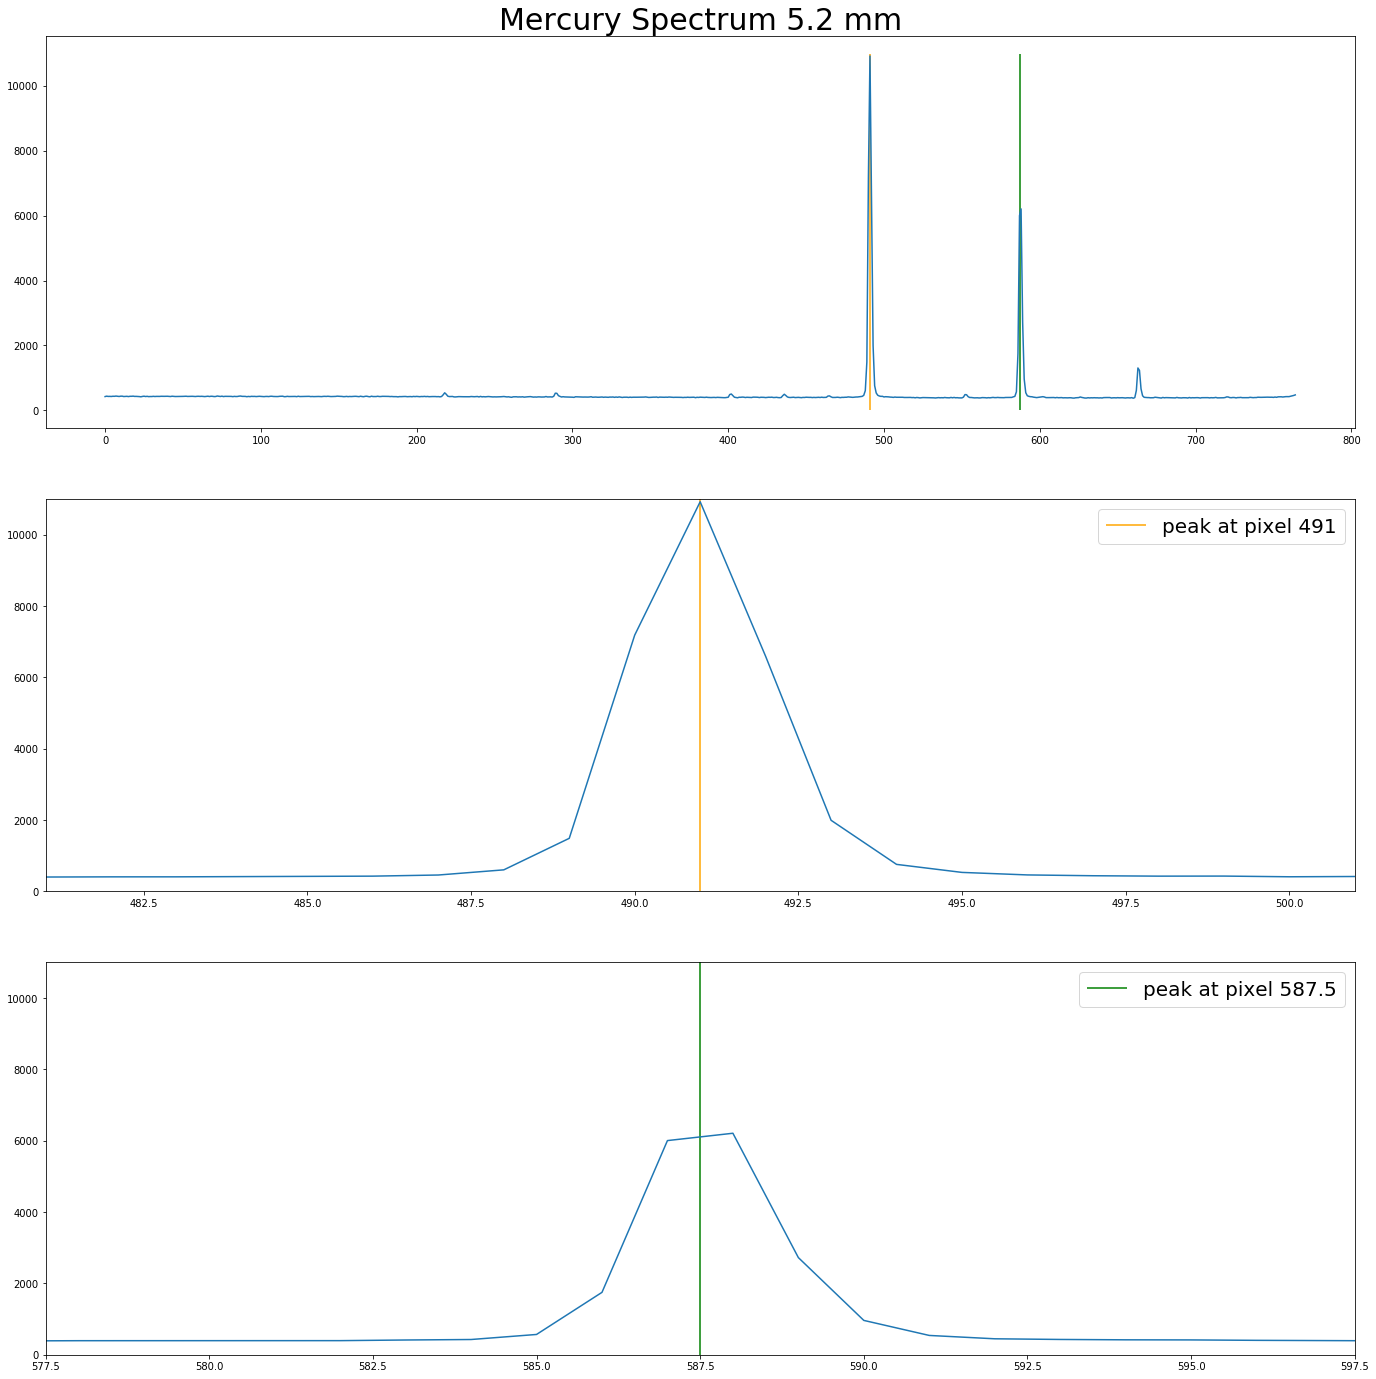

In [30]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 491 ; p2 = 587.5
meas = Micrometer[index]


fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [31]:

l1 = 6965.43

l2 = 7067.22

#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 138.27842559421504 mm
incedent angle: 0.20825247665065857 rad


Text(0.5, 0.98, 'Sun Spectra')

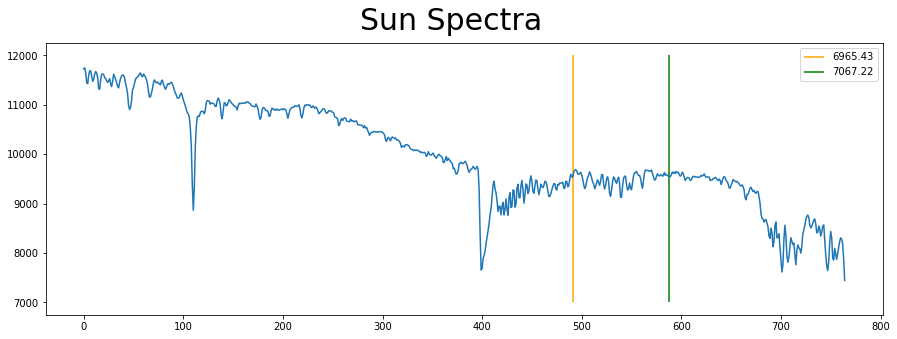

In [32]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=7000
sun_max = 12000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

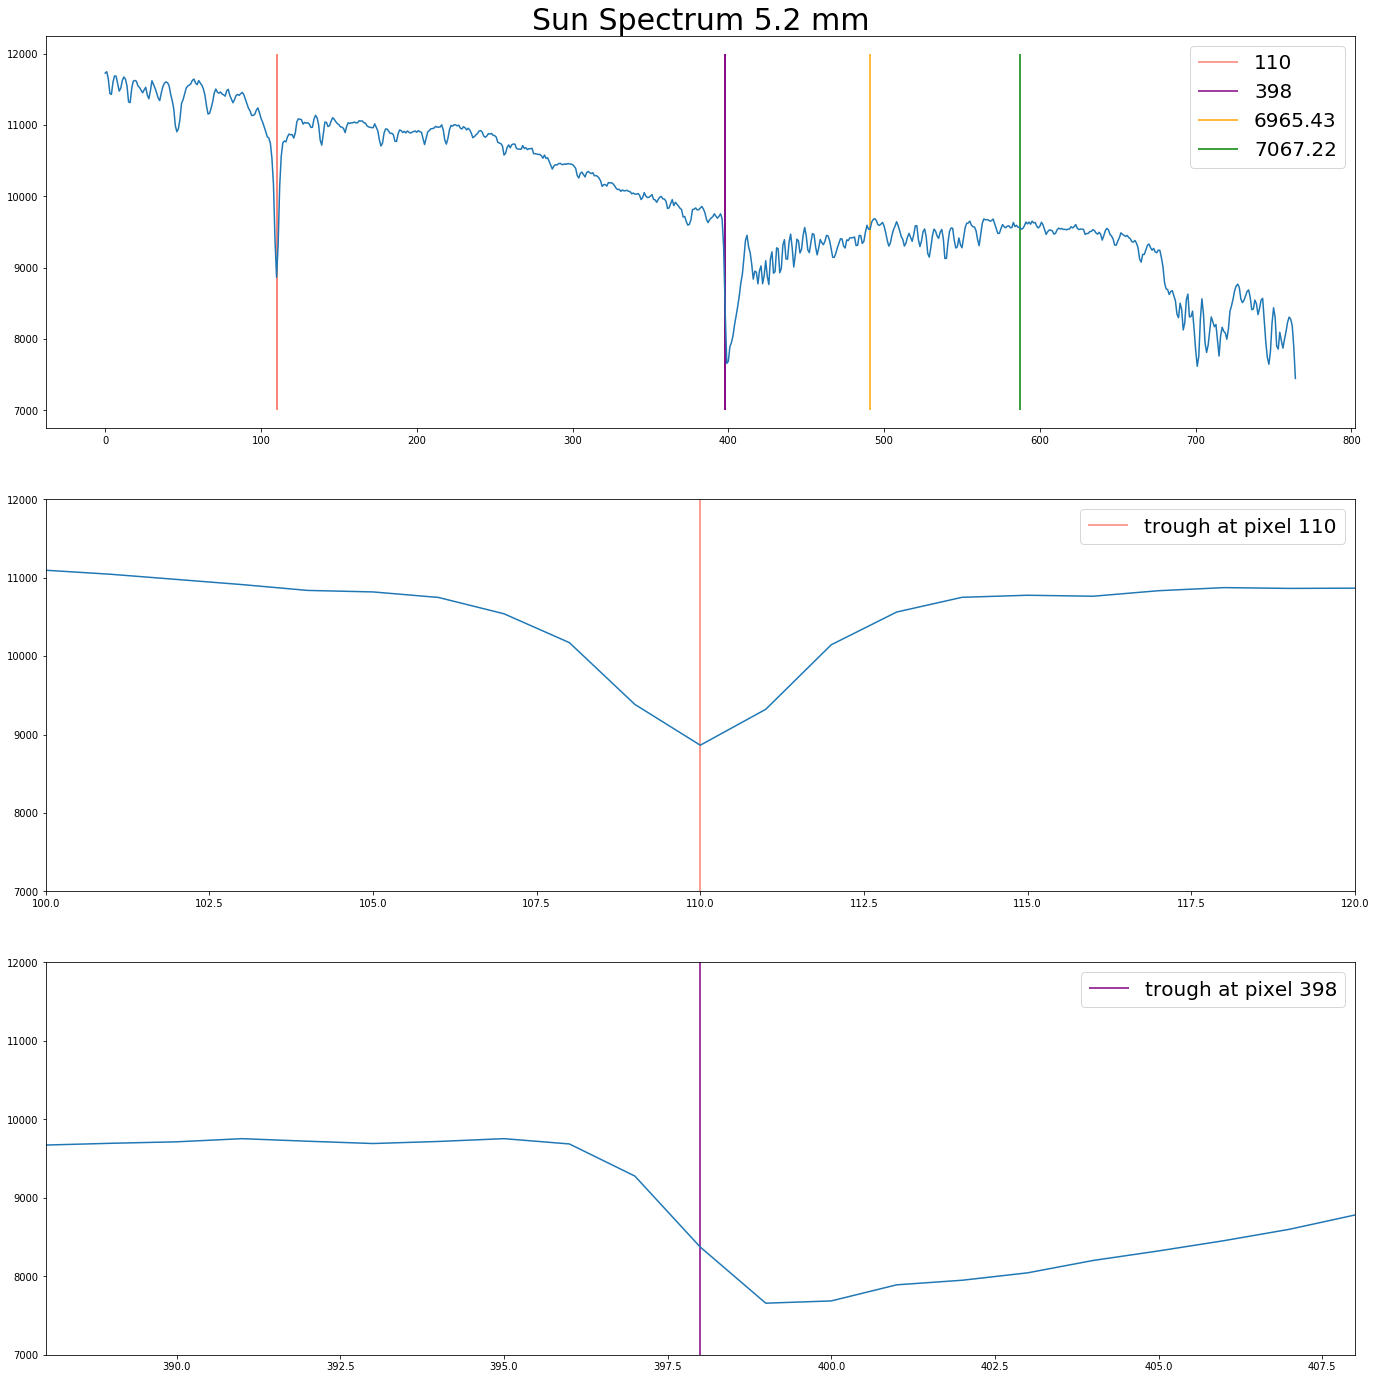

In [33]:
psun1 = 110
psun2 = 398

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [34]:
# lam1 = 5168.90

# lam1 = 4668.14 
# lam1 = 4861.34
# lam1 = 4861.3615 # H
 
# lam1 = 4307.90 
# lam1 = 4307.90 
# lam1 = 4307.90 
# lam1 = 4307.90 
# lam1 = 4307.90 
# lam1 = 4307.90 
lam1 = 6562.81


# lam2 = 4861.34
# lam2 = 5168.90
# lam2 = 5270.39
lam2 = 6867.19


index = ["H\u03B1 C", "O2 B"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df4 = pd.DataFrame(frame, index=index)
display(df4)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Hα C           5.2              6563.544093                    6562.81   
O2 B           5.2              6867.331865                    6867.19   

      Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Hα C   0.734093   0.011186         138.278426          0.208252  
O2 B   0.141865   0.002066         138.278426          0.208252

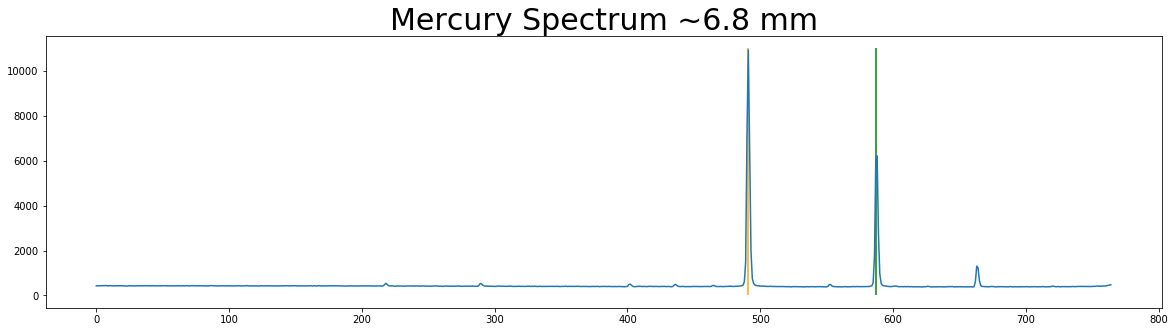

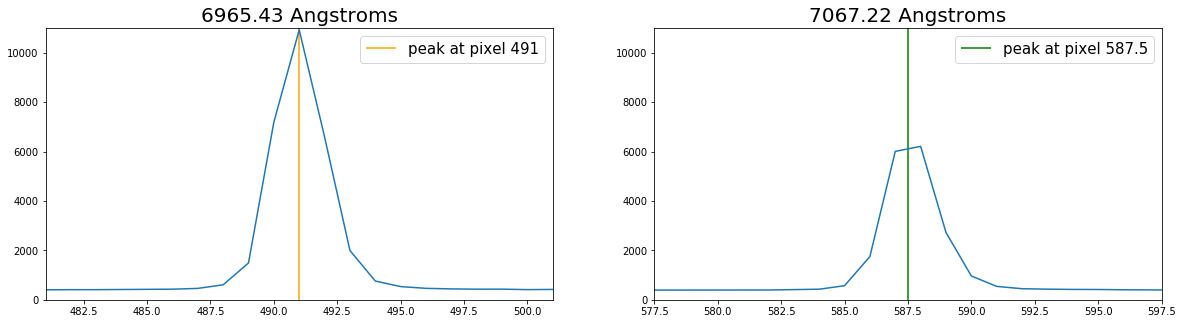

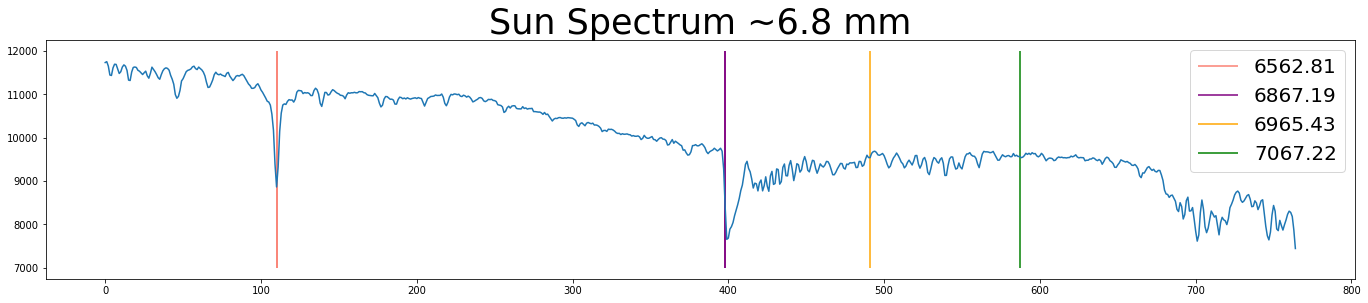

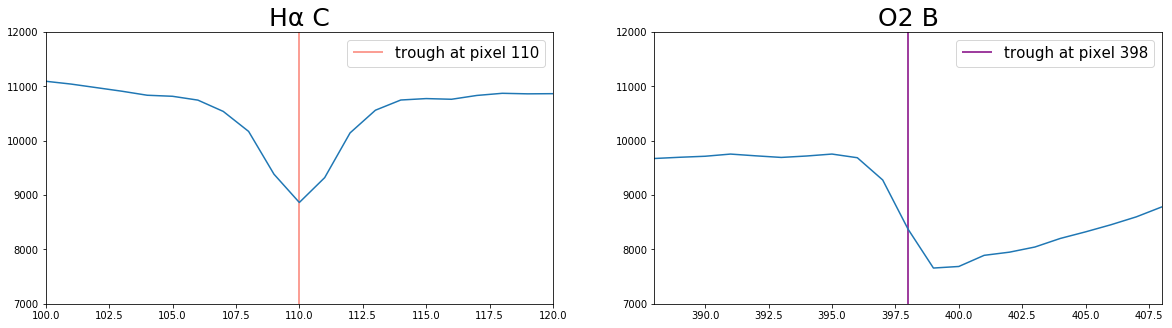

In [35]:
print_plot(df4, "~6.8", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

# 5.6

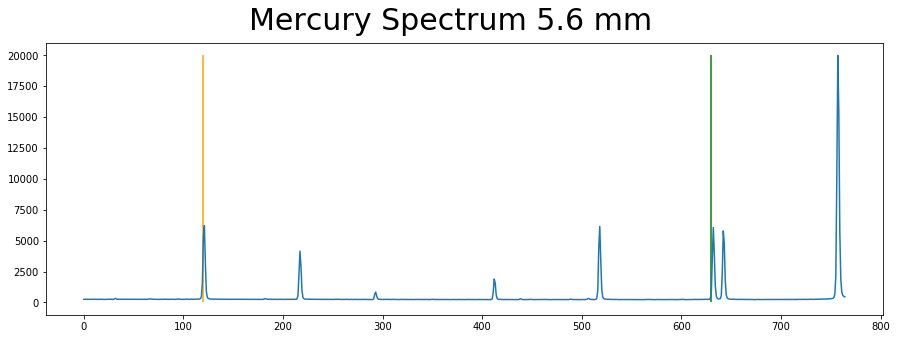

In [36]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 4
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 120 ; p2 = 630
y_min = 0
height = 20000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

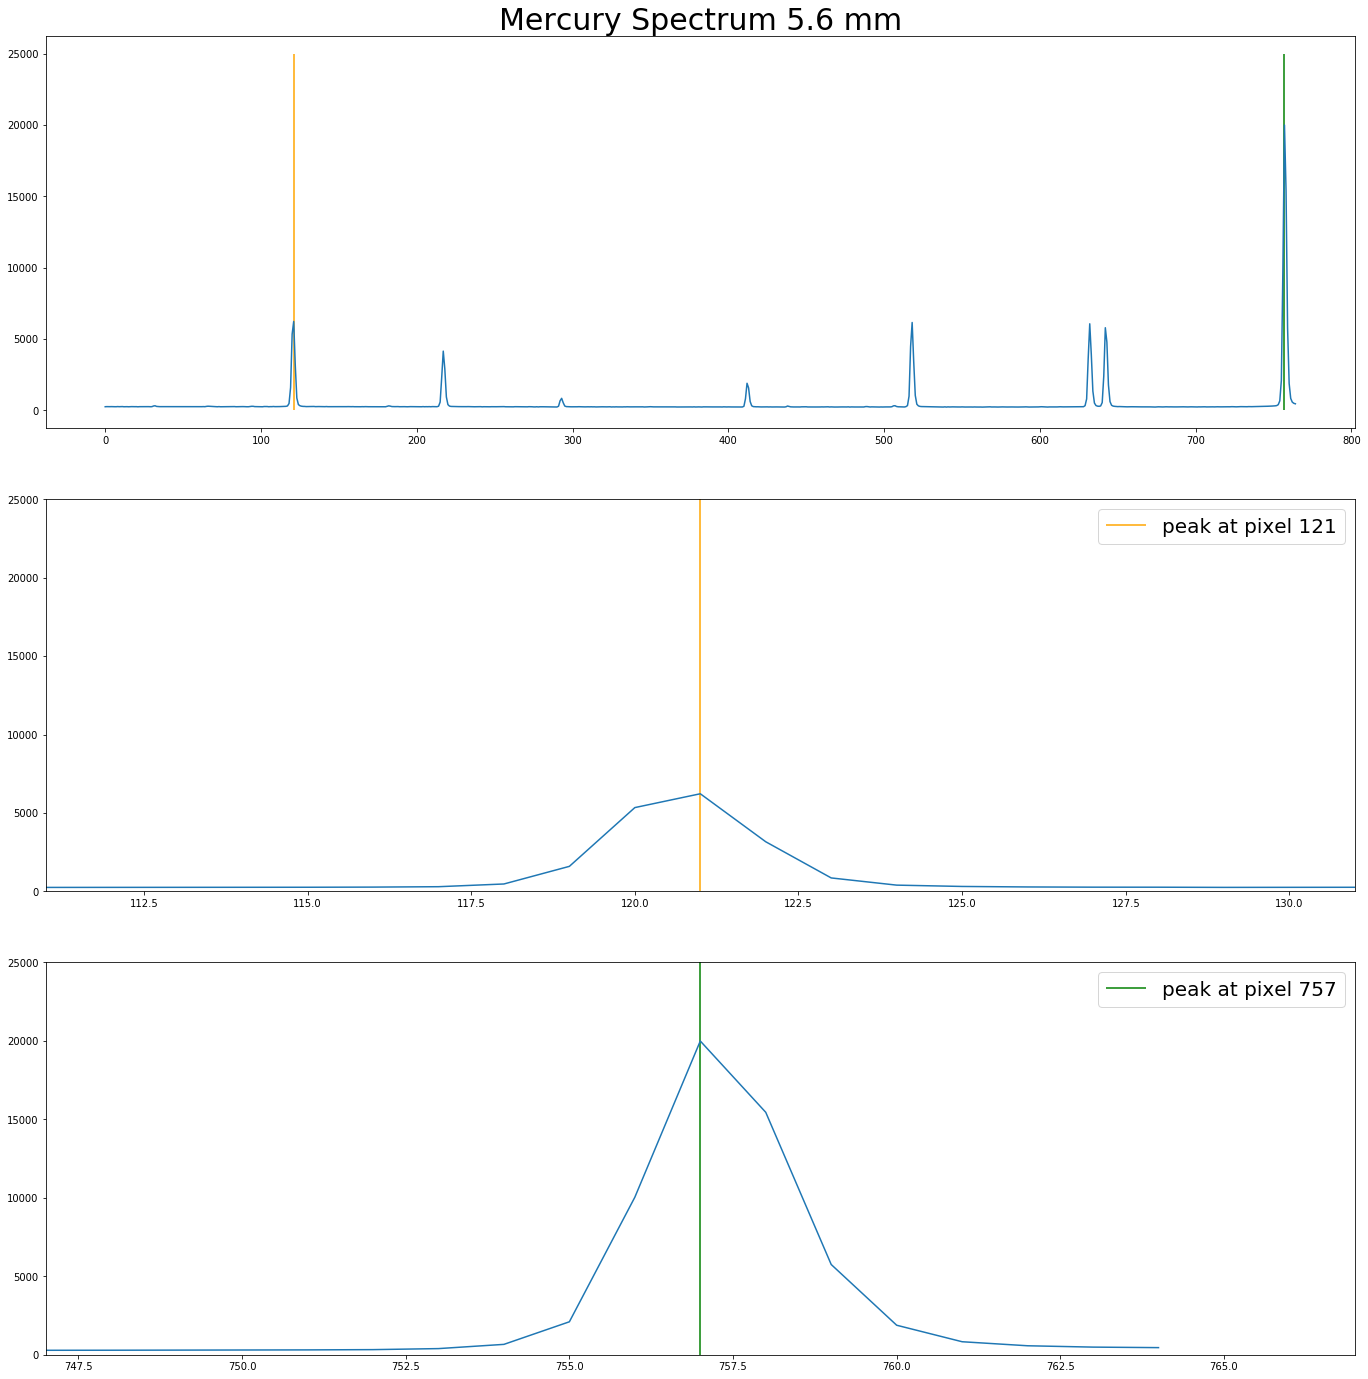

In [37]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 121 ; p2 = 757 #632
# p2 = 518
meas = Micrometer[index]
y_min = 0
height = 25000

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [38]:
l1 = 6965.43

# l2 = 7503.87
l2 = 7635.11

#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 138.1605221993093 mm
incedent angle: 0.22029407039017204 rad


Text(0.5, 0.98, 'Sun Spectra')

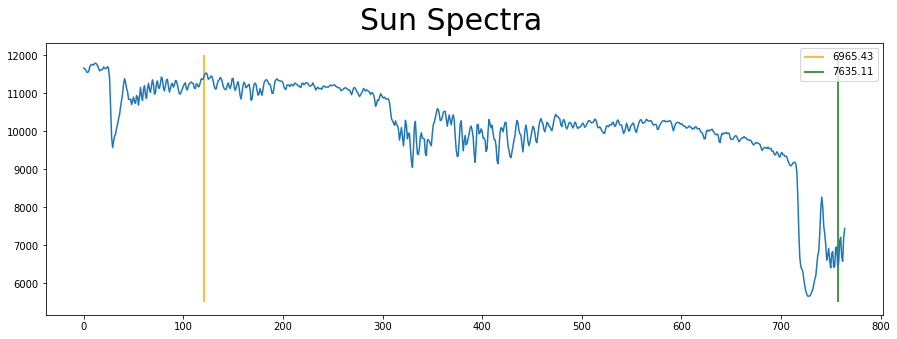

In [39]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=5500
sun_max = 12000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

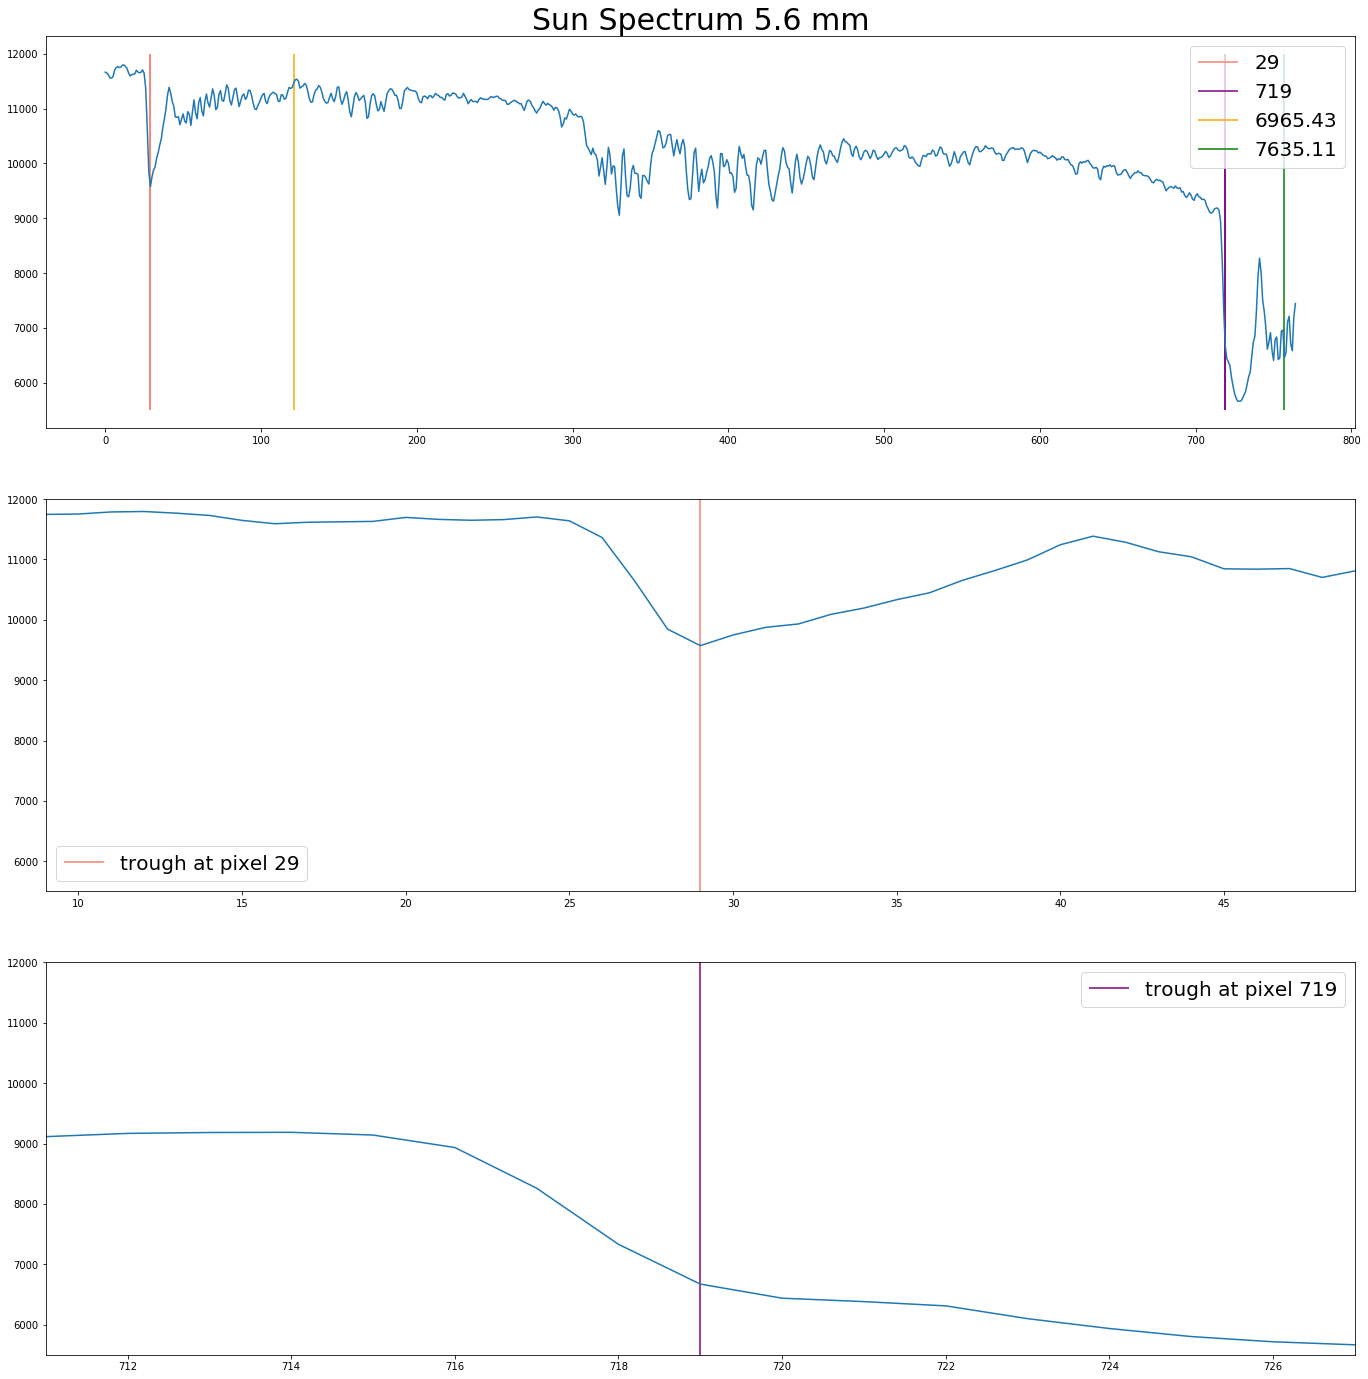

In [40]:
psun1 = 29
psun2 = 719
#722

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-20, psun1+20)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-8, psun2+8)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [41]:
lam1 = 6867.19

lam2 = 7593.7

index = ["O2 B", "O2 A"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df5 = pd.DataFrame(frame, index=index)
# df.append(df5)
display(df5)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
O2 B           5.6              6868.558050                    6867.19   
O2 A           5.6              7595.097673                    7593.70   

      Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
O2 B   1.368050   0.019922         138.160522          0.220294  
O2 A   1.397673   0.018406         138.160522          0.220294

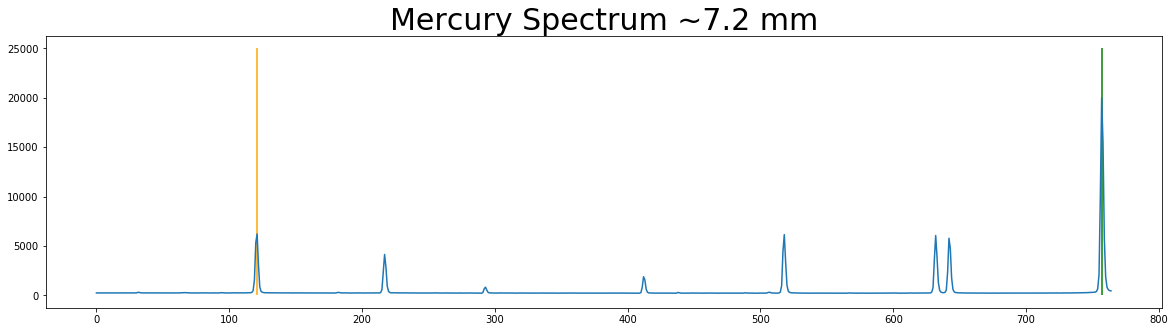

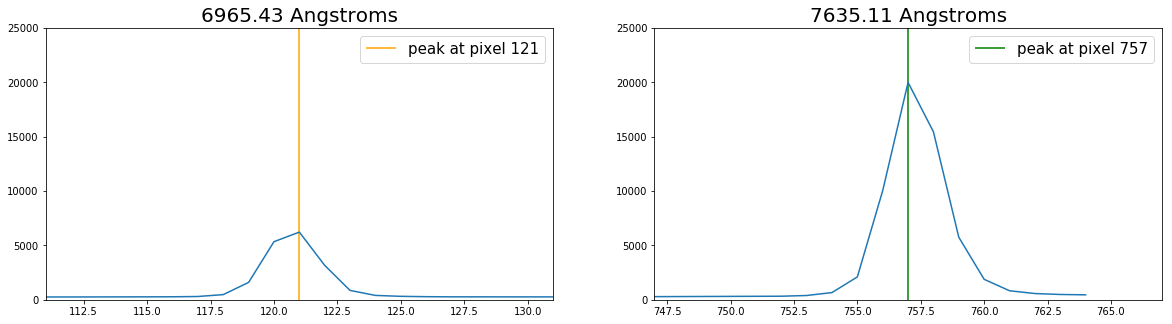

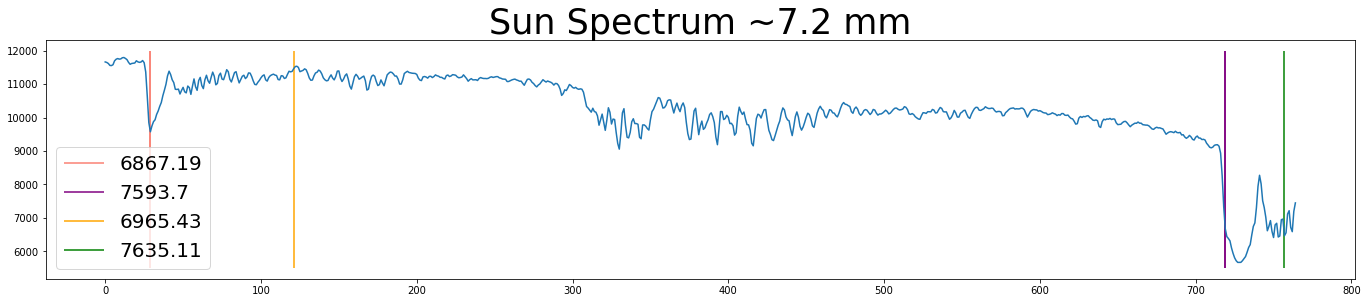

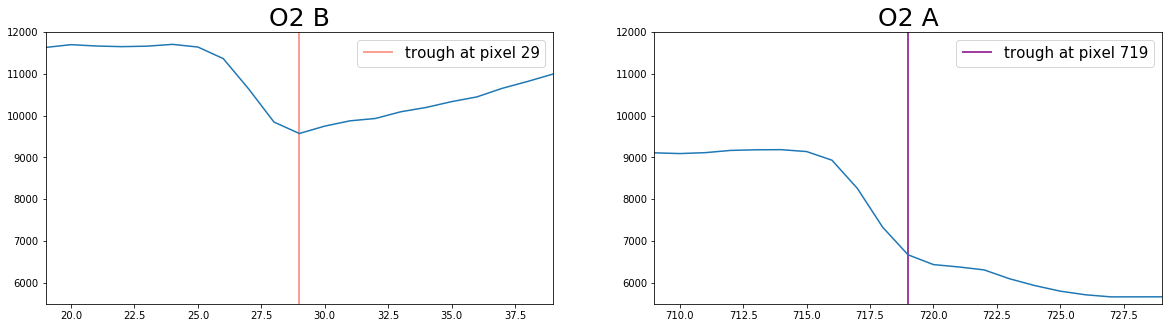

In [42]:
print_plot(df5, "~7.2", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

# 6.0

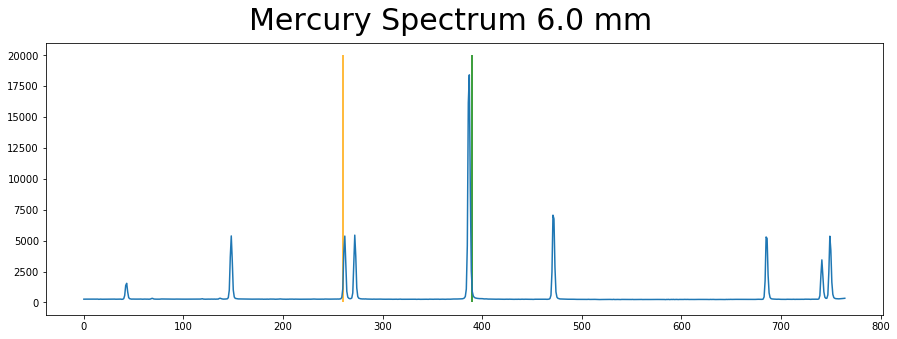

In [43]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 5 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 260 ; p2 = 390
y_min = 0
height = 20000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])




plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

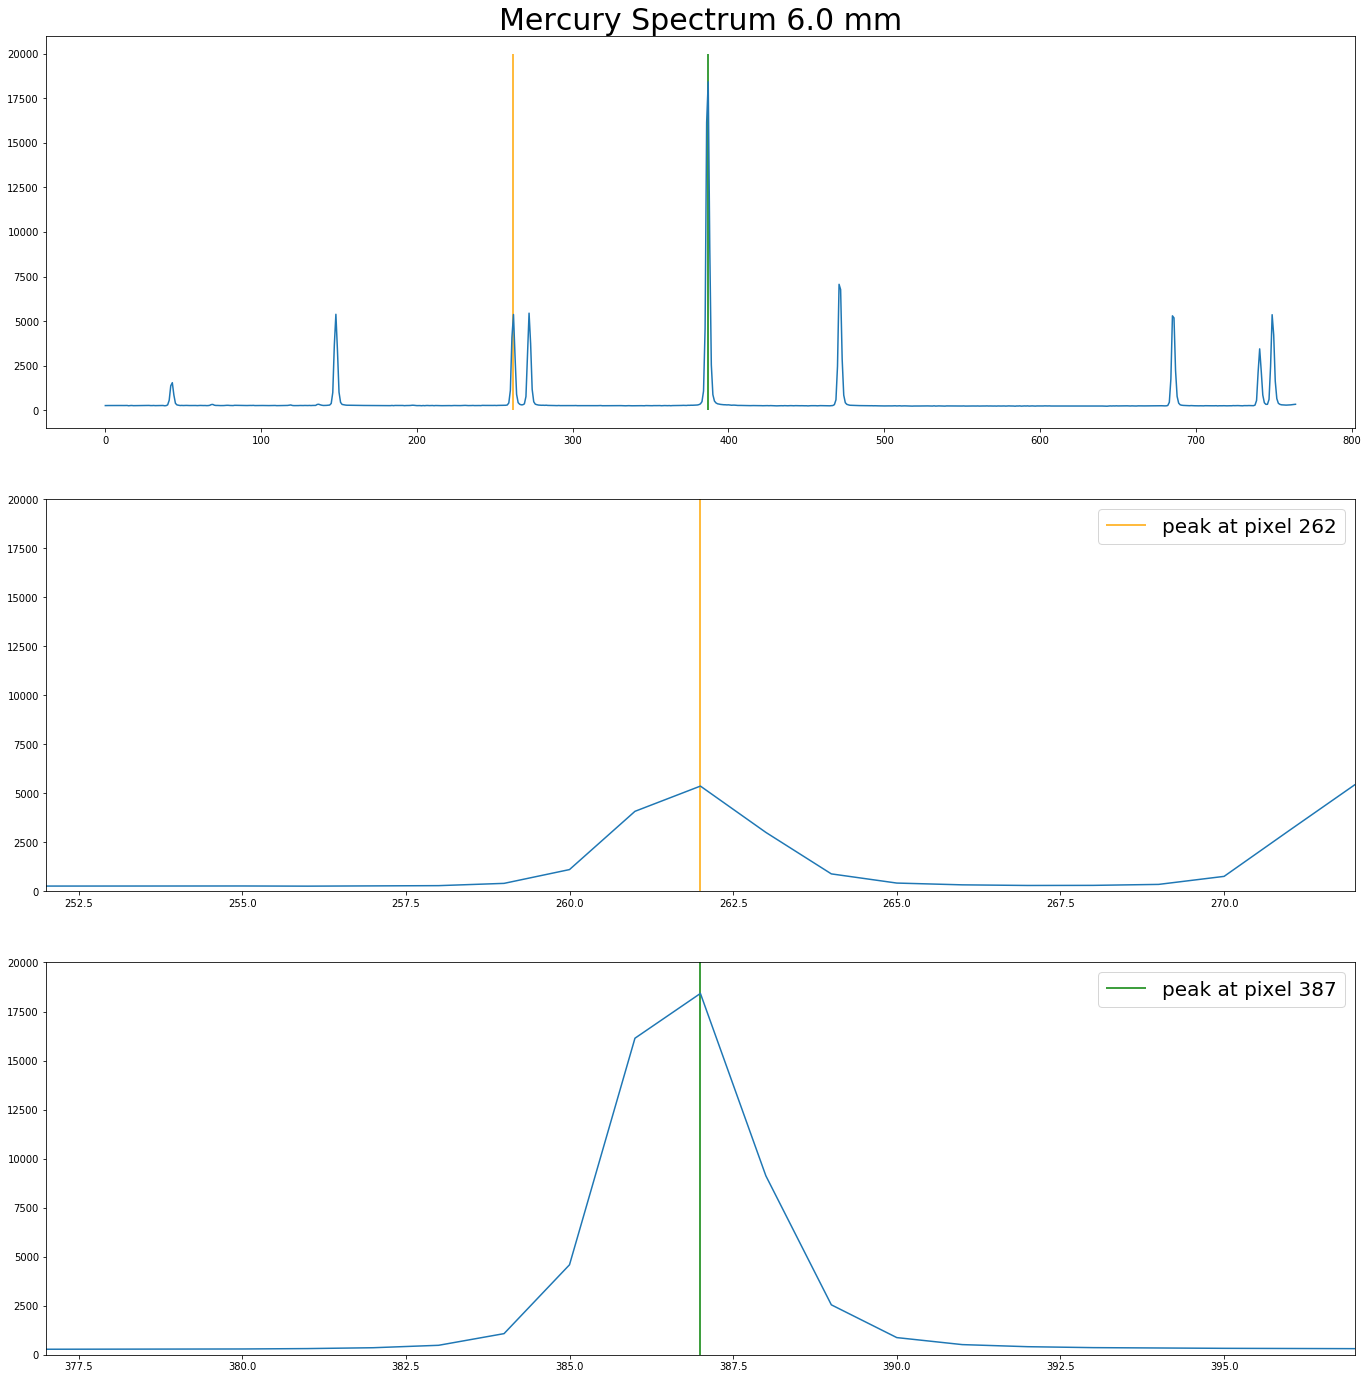

In [44]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 262 ; p2 = 387
meas = Micrometer[index]


fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [45]:

l1 = 7503.87




l2 = 7635.11

#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 138.17549837689205 mm
incedent angle: 0.23236243304505957 rad


Text(0.5, 0.98, 'Sun Spectra')

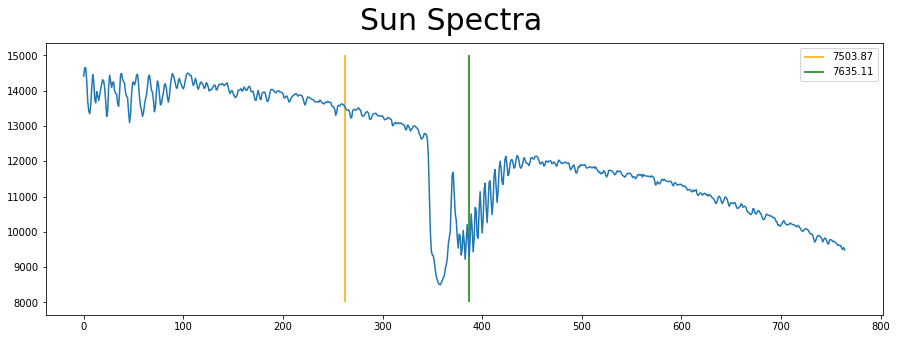

In [46]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=8000
sun_max = 15000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

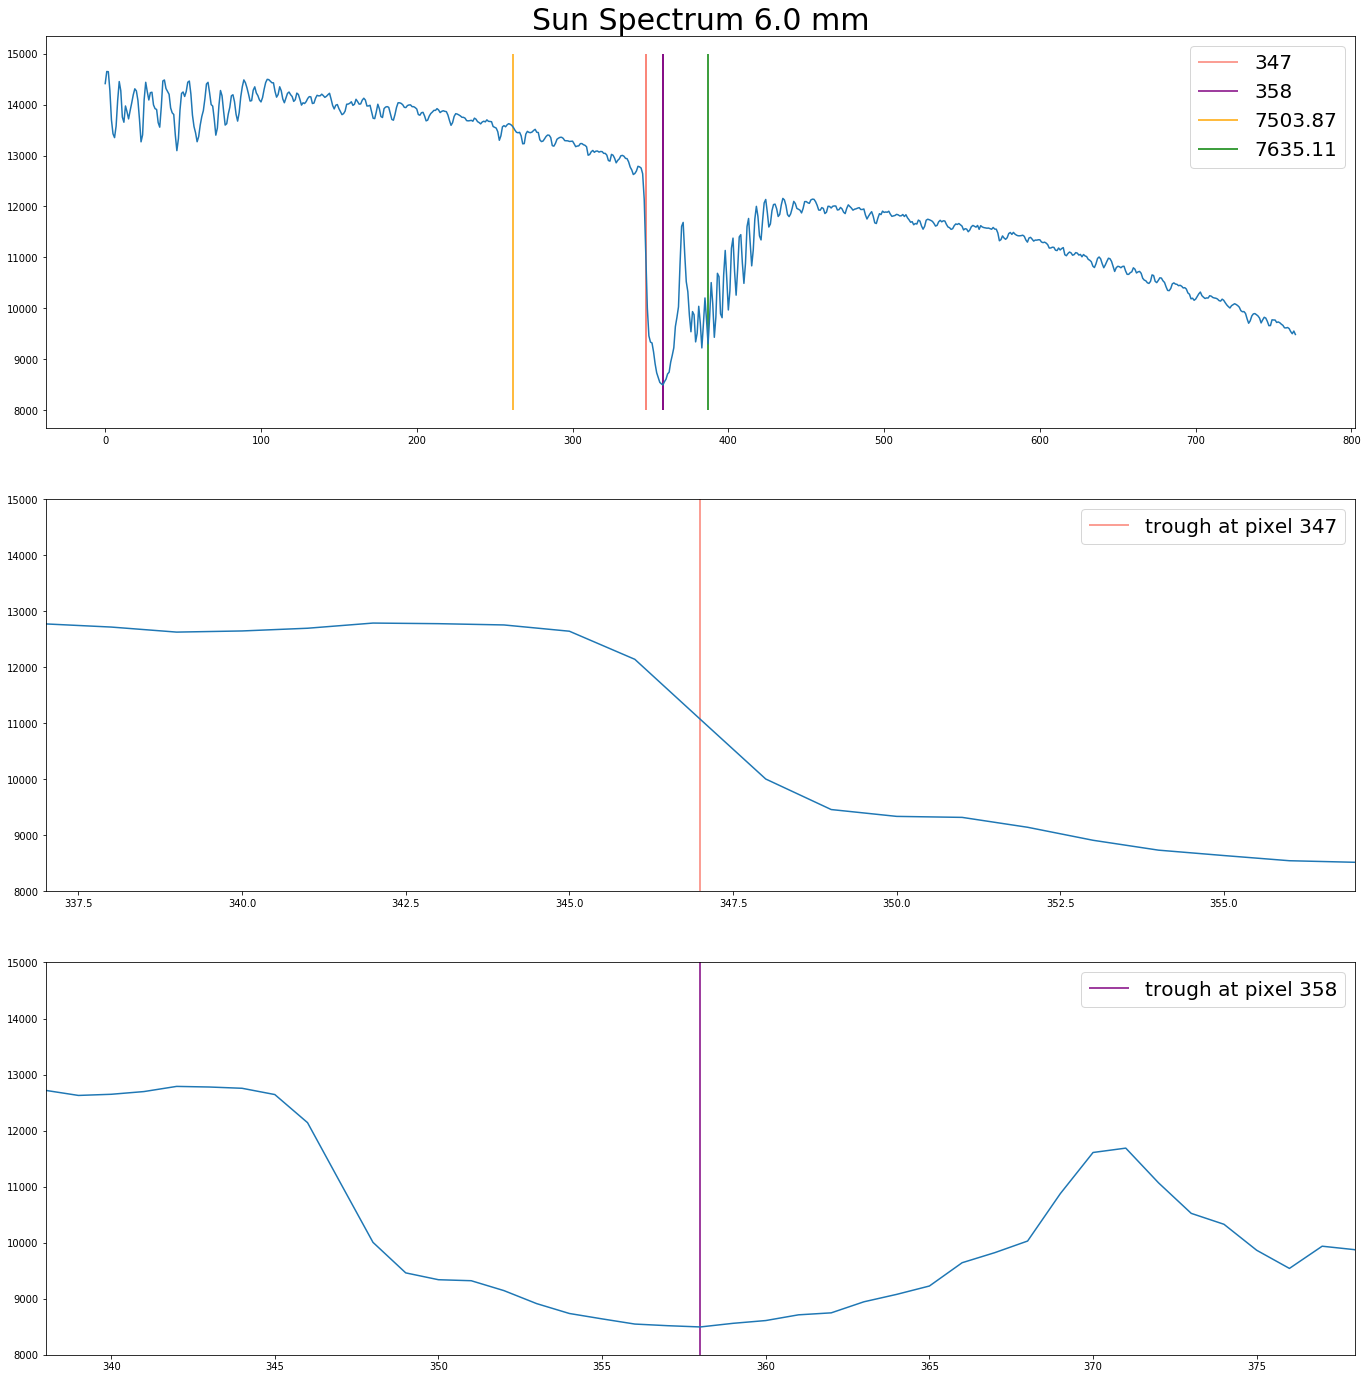

In [47]:
# psun1 = 60
psun1 = 347
psun2 = 358

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-20, psun2+20)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [48]:
lam1 = 7593.70 # O A
# lam1 = 7416
# lam1 = 7292.96 # In


# lam2 = 7604.92 #Xe
lam2 = 7604.63
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 
# lam2 = 4668.14 

index = ["O2 A", "Ne II"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df6 = pd.DataFrame(frame, index=index)
#df.append(df6)
display(df6)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
O2 A            6.0               7593.11320                    7593.70   
Ne II           6.0               7604.66232                    7604.63   

       Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
O2 A    -0.58680  -0.007727         138.175498          0.232362  
Ne II    0.03232   0.000425         138.175498          0.232362

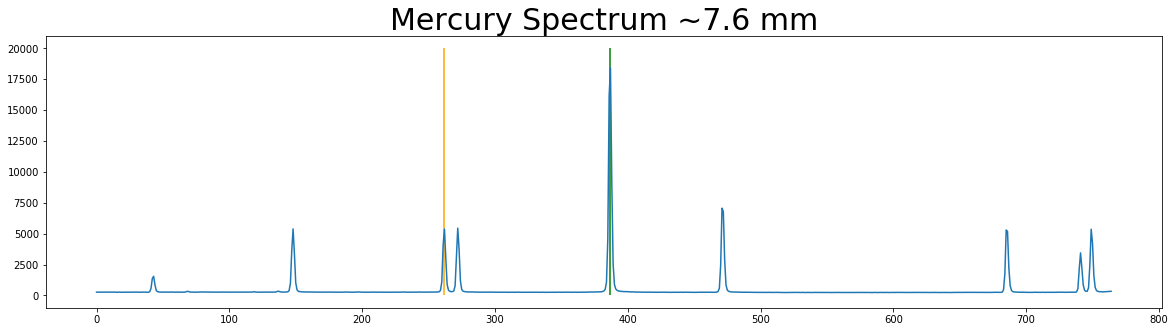

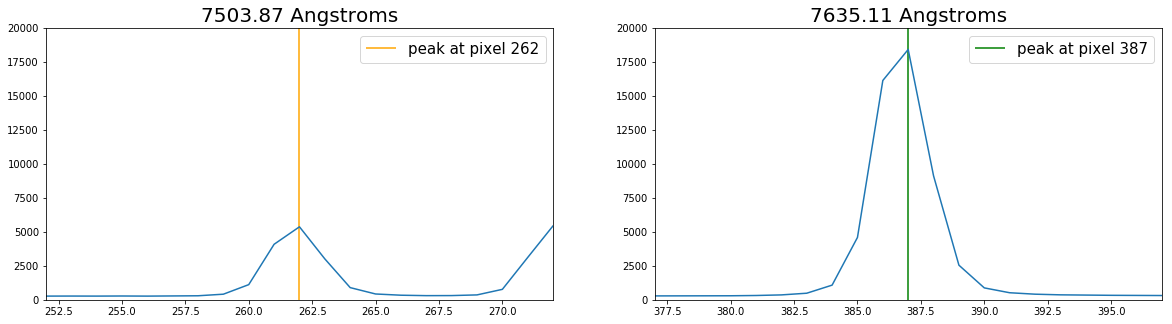

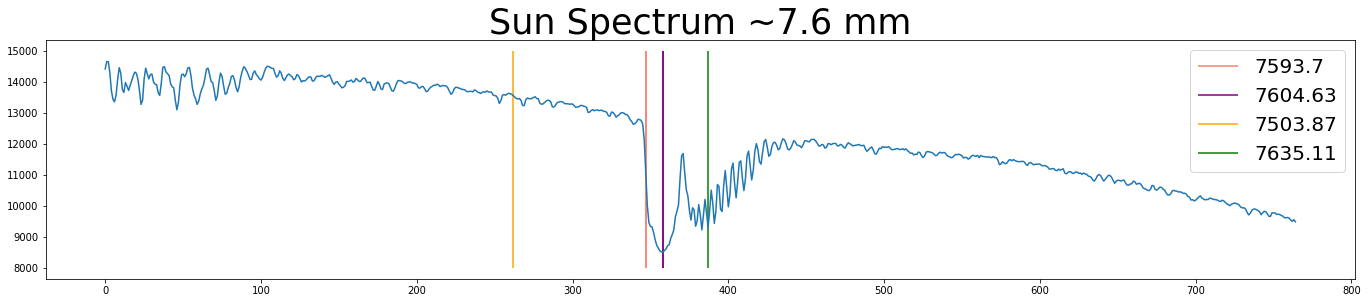

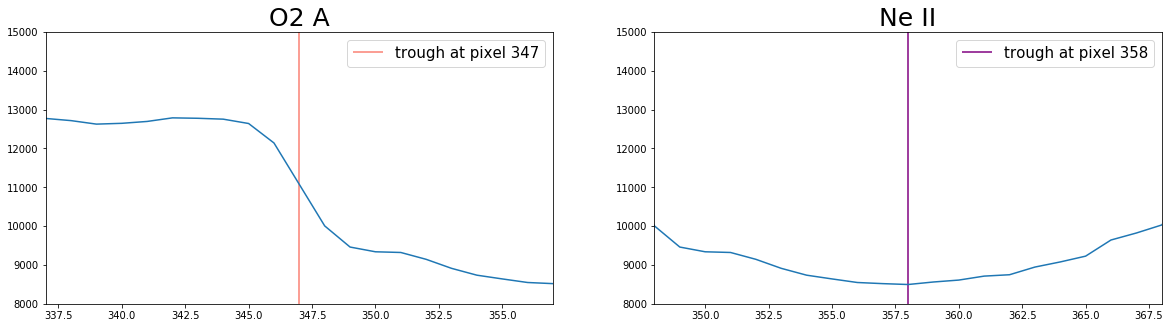

In [49]:
print_plot(df6, "~7.6", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

# 6.4

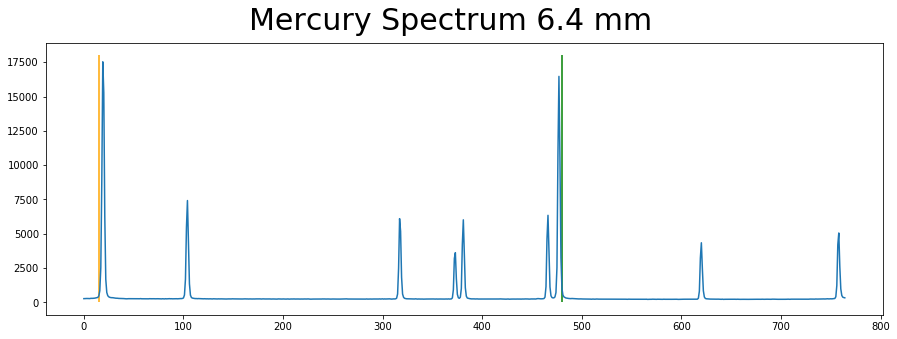

In [50]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 6 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 15 ; p2 = 480
y_min = 0
height = 18000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])




plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

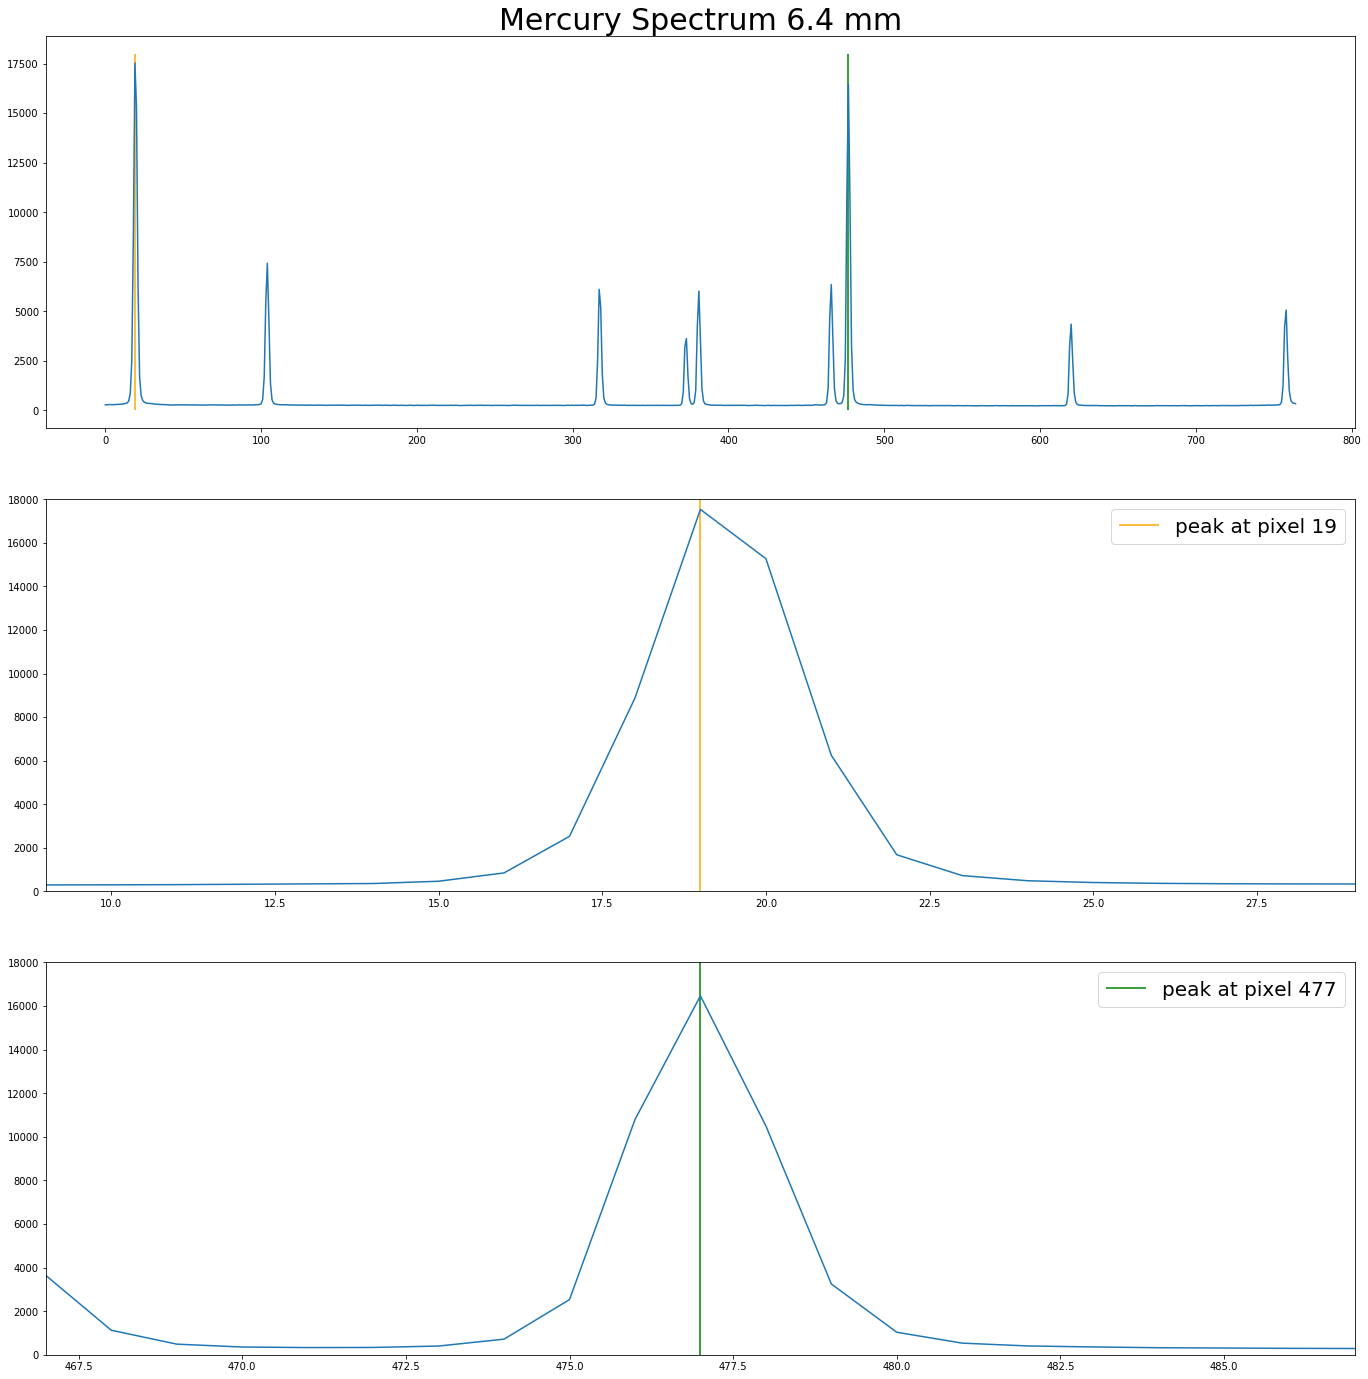

In [51]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 19 ; p2 = 477


fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [52]:
l1 = 7635.11

l2 = 8115.31



#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 137.96400299271113 mm
incedent angle: 0.24434821231975343 rad


Text(0.5, 0.98, 'Sun Spectra')

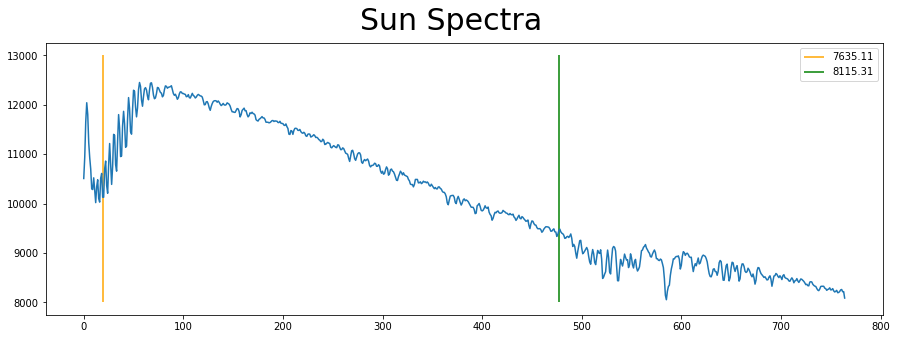

In [53]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=8000
sun_max = 13000
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

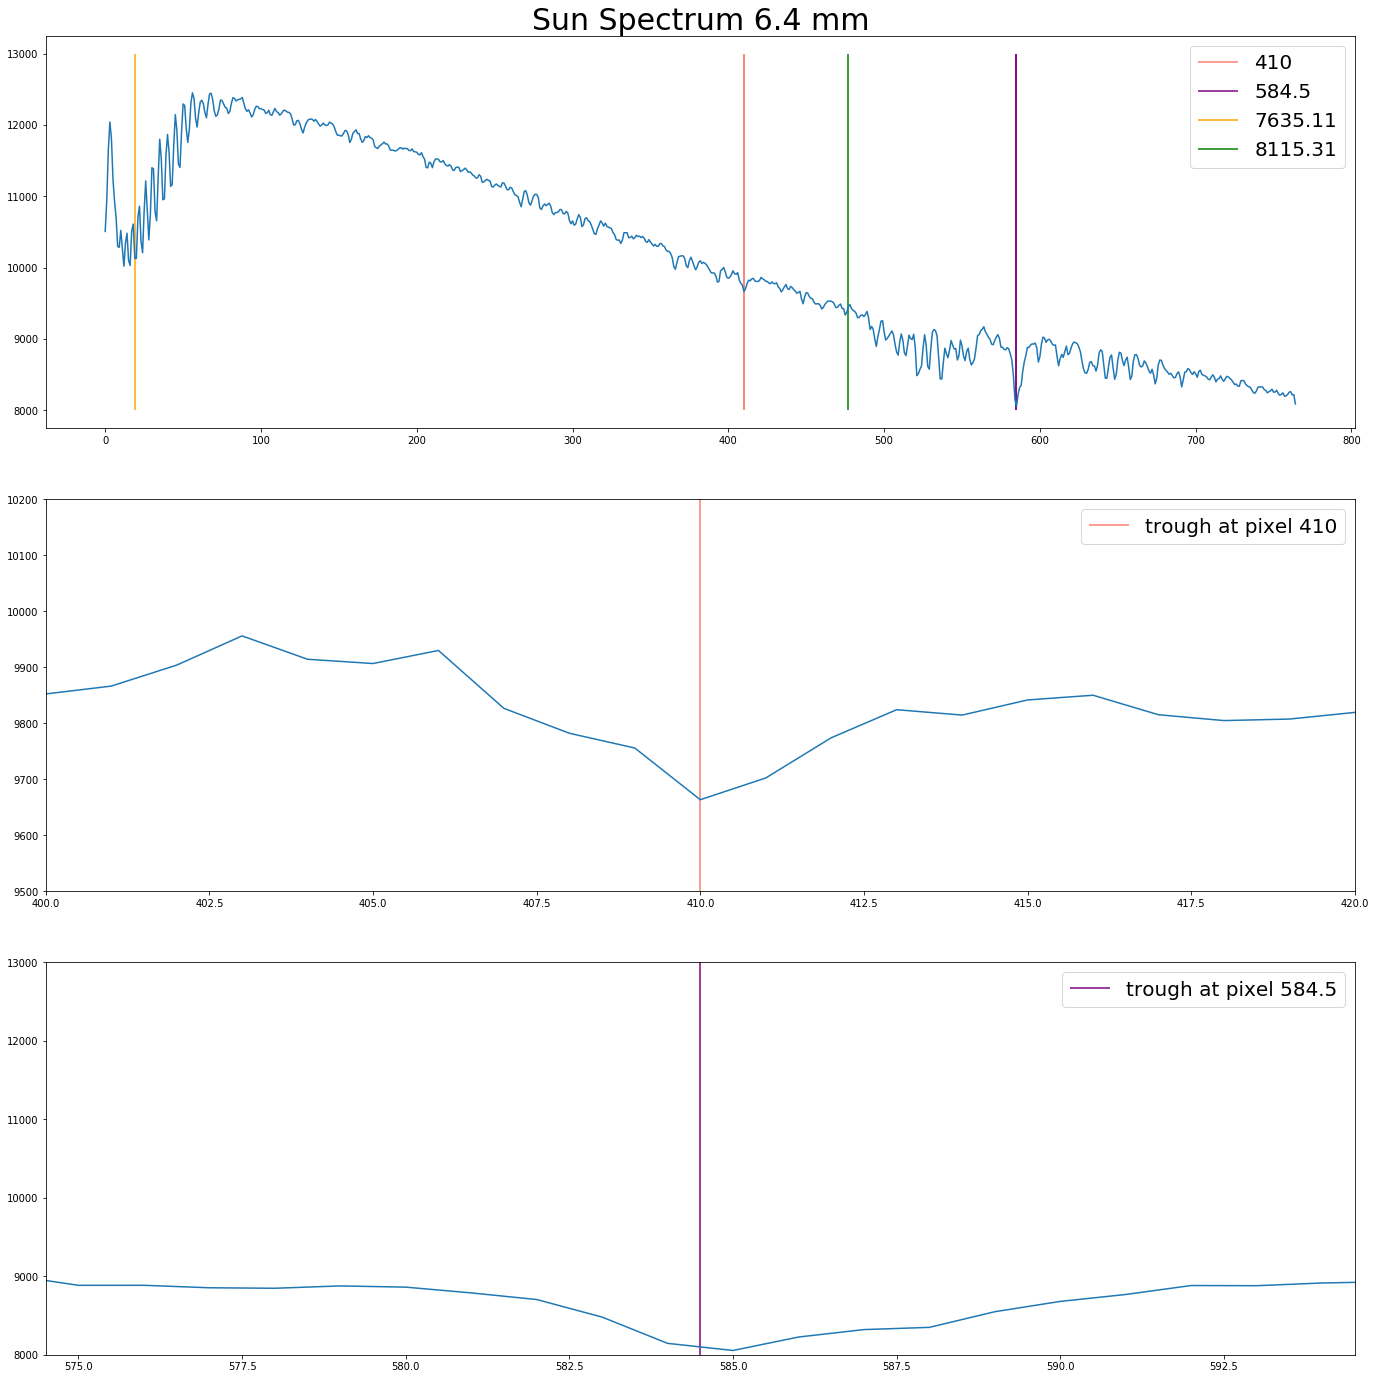

In [54]:
psun1 = 410
psun2 = 584.5

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(9500, 10200)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [55]:
# lam1 = 7635.22 #AlIII
# lam1 = 7624.39 HfI
lam1 = 8046.05 #FeI

8220.3770 # FeI
lam2 = 8226.96


index = ["Fe I", "O2 Z"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df7 = pd.DataFrame(frame, index=index)
display(df7)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Fe I           6.4              8045.062402                    8046.05   
O2 Z           6.4              8228.020699                    8226.96   

      Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Fe I  -0.987598  -0.012274         137.964003          0.244348  
O2 Z   1.060699   0.012893         137.964003          0.244348

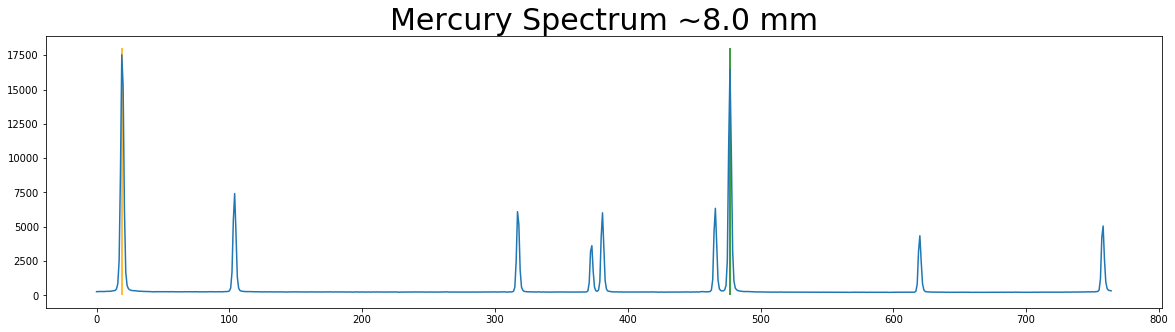

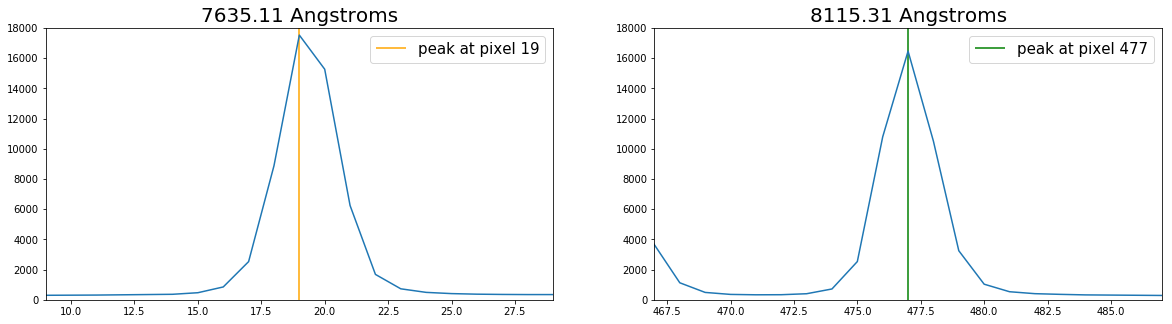

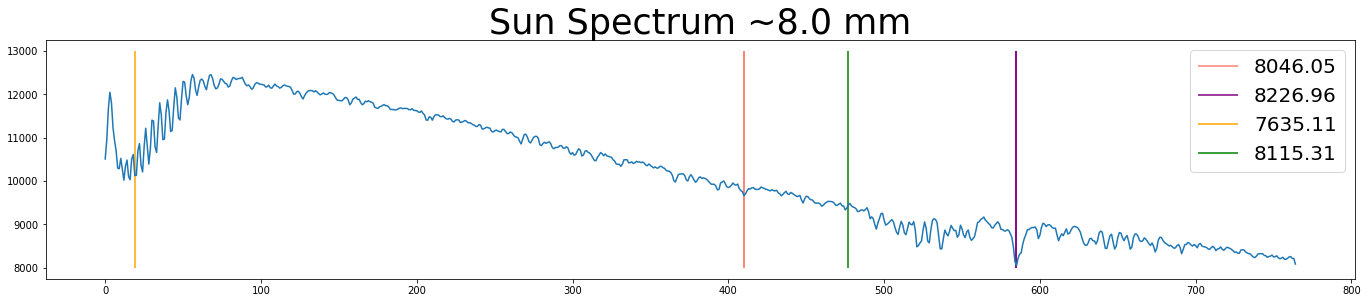

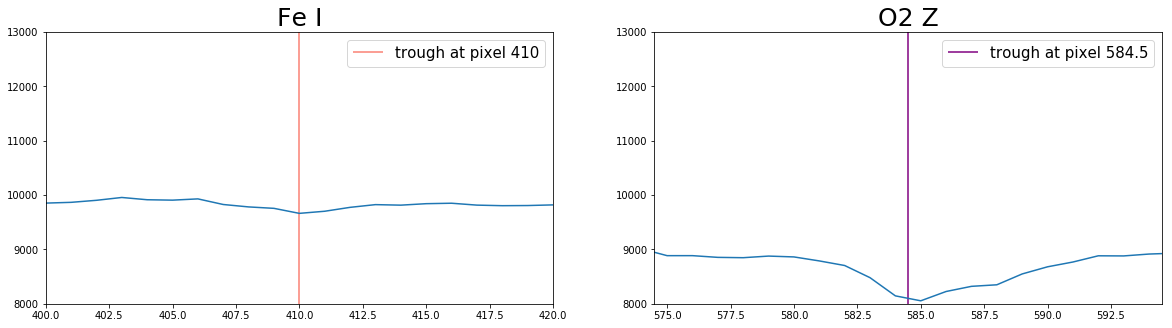

In [56]:
print_plot(df7, "~8.0", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

# 6.8

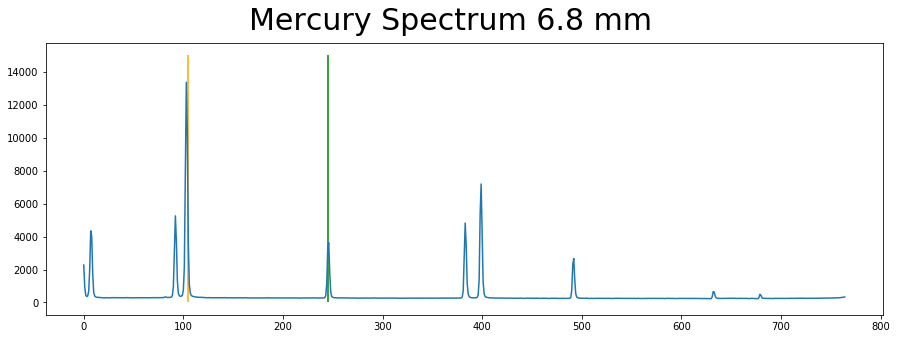

In [57]:
# Change the index for the image you want
fig = plt.figure(figsize= [15,5])

index = 7 #this code ensures we have the same index for sun
data1 = Hg_spectra[index]
plt.plot(data1)

meas = Micrometer[index]
p1 = 105 ; p2 = 245
y_min = 0
height = 15000

plt.vlines([p1, p2], y_min, height, colors=['orange', 'g'])




plt.suptitle("Mercury Spectrum %s mm"%meas, fontsize=30)
plt.show()

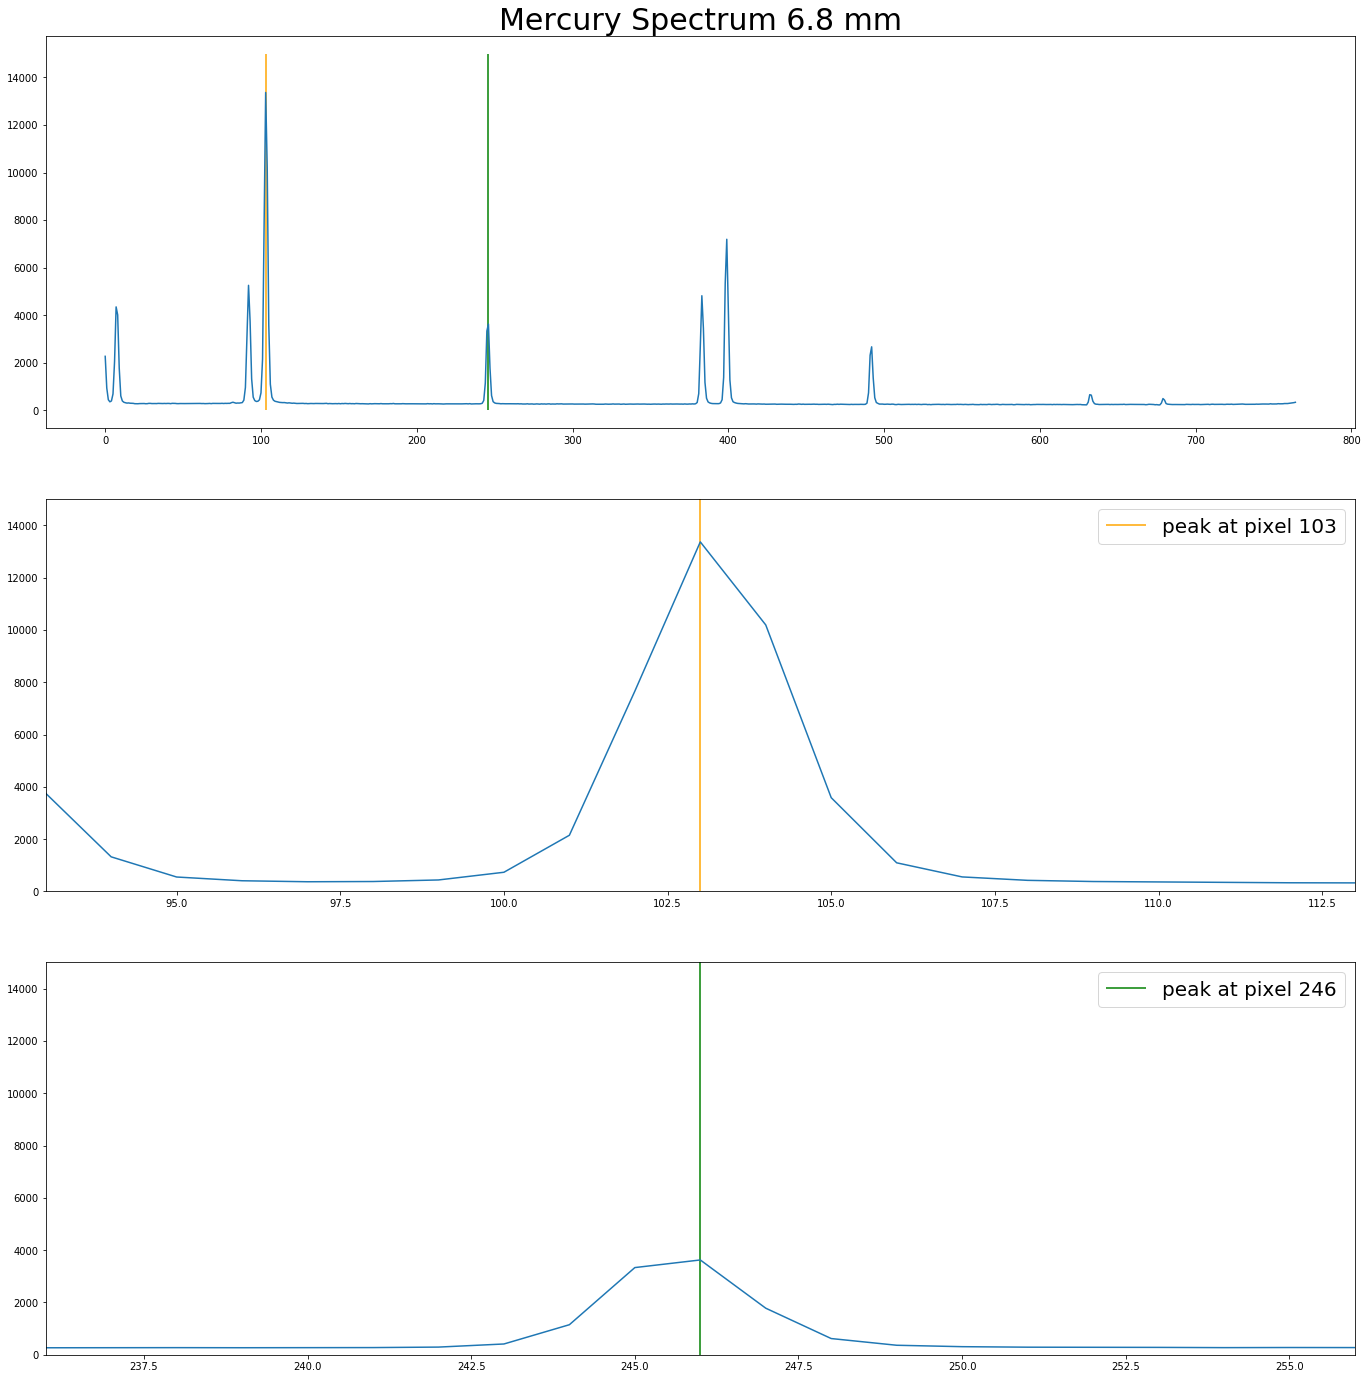

In [58]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 103 ; p2 = 246


fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data1) 
ax0.vlines([p1, p2], y_min, height, colors=['orange', 'g'])
ax0.set_title("Mercury Spectrum %s mm"%meas, fontsize=30)
ax1.plot(data1) ;
ax1.vlines(p1, y_min, height, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data1) 
ax2.vlines(p2, y_min, height, label="peak at pixel {}".format(p2), colors='g')
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(y_min,height)
ax2.set_xlim(p2-10, p2+10)
ax2.set_ylim(y_min,height)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()
 

In [59]:
l1 = 8115.31

l2 = 8264.52


#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)
theta = get_theta(p1, p2, l1, l2)
print("incedent angle:", theta)

# We need to make note of this in a table

calculated focal length: 138.20001378465346 mm
incedent angle: 0.256522191652535 rad


Text(0.5, 0.98, 'Sun Spectra')

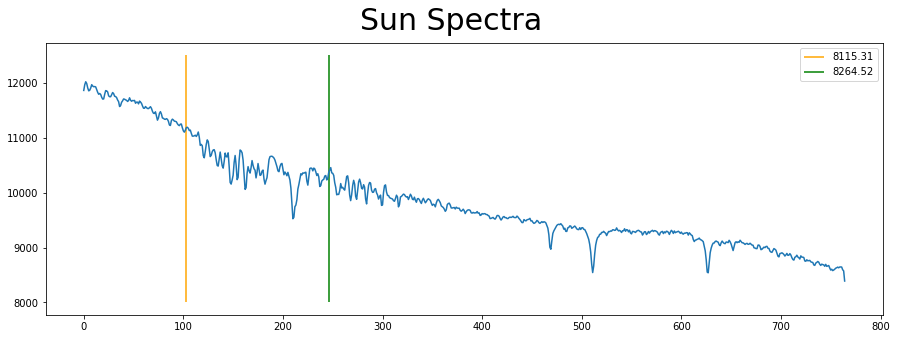

In [60]:
fig = plt.figure(figsize= [15,5])

data2 = Sun_spectra[index]
plt.plot(data2)
sun_min=8000
sun_max = 12500
#plt.plot(p1, c = 'orange', label = l1)
plt.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
plt.vlines(p2, sun_min, sun_max, label = l2, colors='g')
plt.legend()


plt.suptitle("Sun Spectra", fontsize=30)

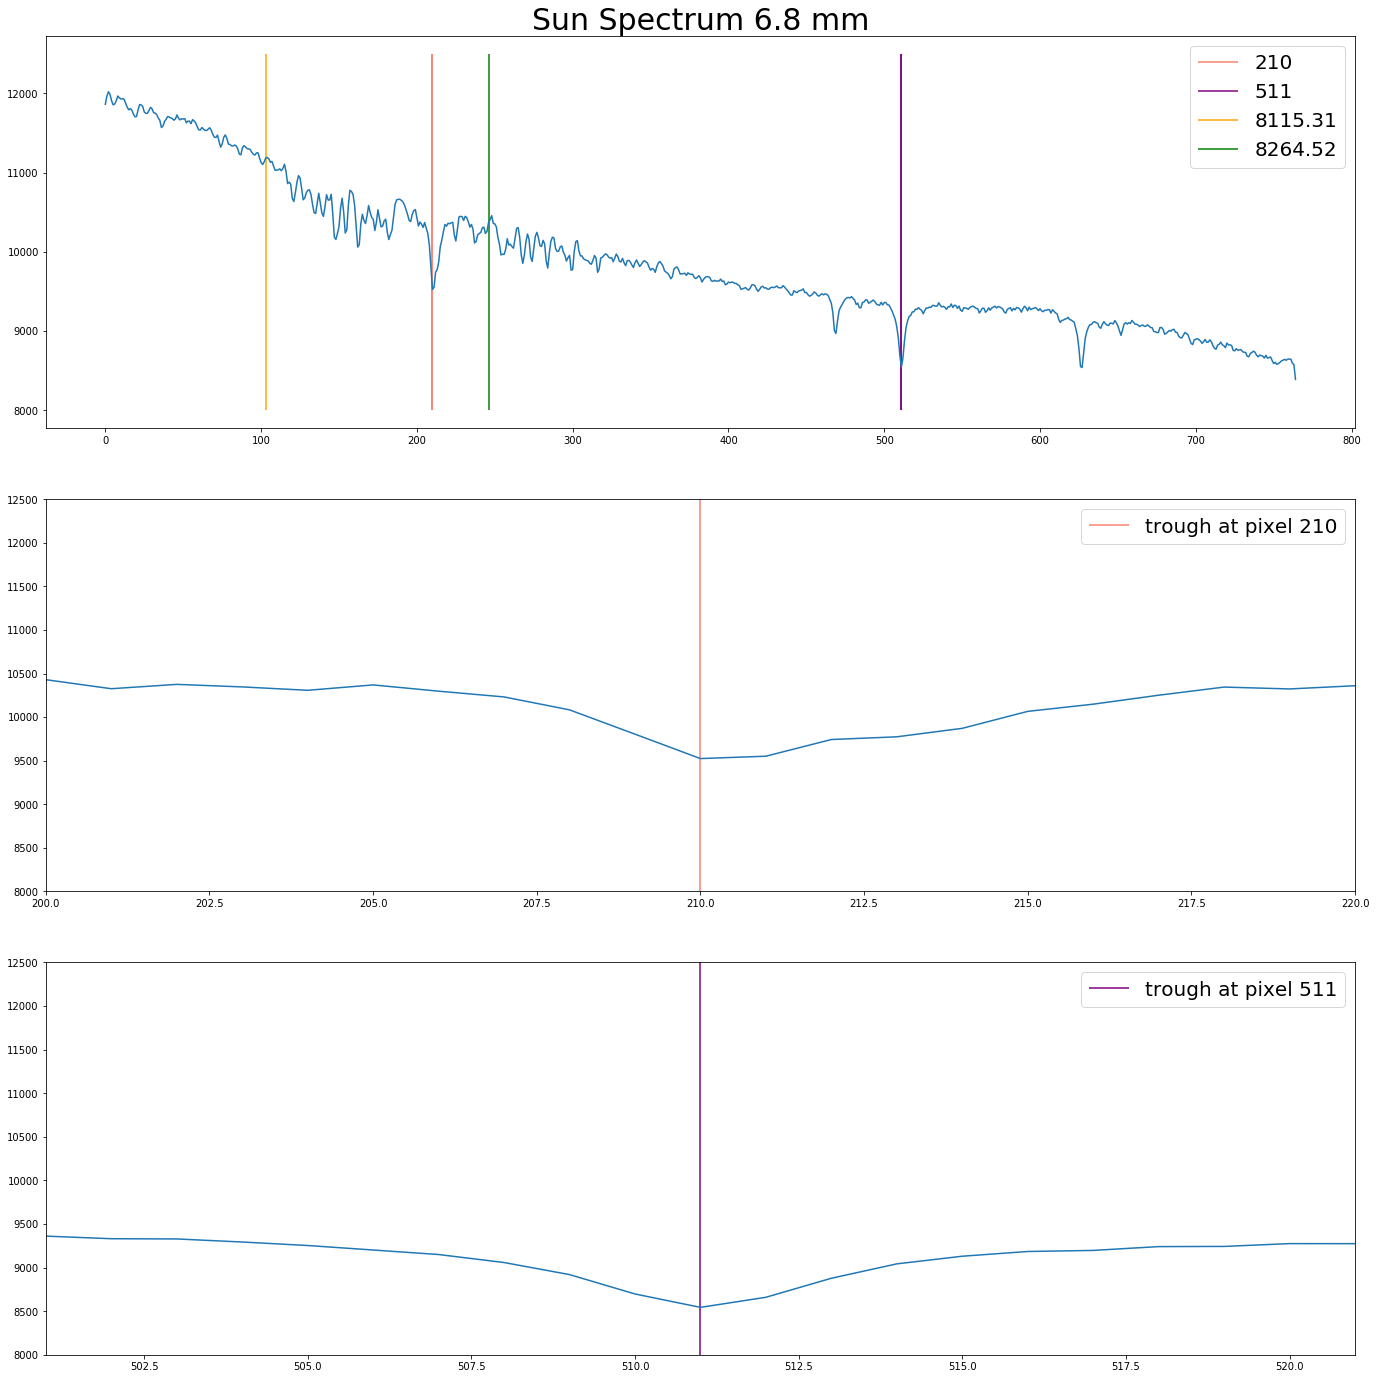

In [61]:
psun1 = 210
psun2 = 511

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum %s mm"%meas, fontsize=30)
img = ax0.plot(data2)

ax1.plot(data2);
# ax1.set_title("Ca K", fontsize=30) #Change this title for the lines you are including
ax1.vlines(psun1, sun_min, sun_max, label="trough at pixel {0}".format(psun1), colors='salmon')

ax2.plot(data2);
# ax2.set_title("Ca H", fontsize=30) #Change this title for the lines you are including
ax2.vlines(psun2, sun_min, sun_max, label="trough at pixel {}".format(psun2), colors='purple')

ax0.vlines([psun1, psun2], sun_min,sun_max, colors=['salmon', 'purple']) #may need to change for each spectrum?
ax0.vlines(psun1, sun_min, sun_max, label = psun1, colors='salmon')
ax0.vlines(psun2, sun_min, sun_max, label = psun2, colors='purple')

ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(sun_min, sun_max)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(sun_min, sun_max)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax0.vlines(p1, sun_min, sun_max, label = l1, colors='orange')
ax0.vlines(p2, sun_min, sun_max, label = l2, colors='g')
ax0.legend(fontsize=20)

#ply.savefig('spectra.pdf')
plt.show()

In [62]:
lam1 = 8226.96
lam2 = 8541.58  


index = ["O2 Z", "Ne II"] #Change these for each spectrum

# I don't THINK you need to change these, just make sure everything appears in the below table, inclusing K and H
frame = {u"Microm. (mm)" : meas,
         u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2],         
         u"Focal Length (mm)" : focal_len,
         u"Inc. Angle (rad)" : theta}

df8 = pd.DataFrame(frame, index=index)
display(df8)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
O2 Z            6.8              8226.956643                    8226.96   
Ne II           6.8              8541.028042                    8541.58   

       Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
O2 Z   -0.003357  -0.000041         138.200014          0.256522  
Ne II  -0.551958  -0.006462         138.200014          0.256522

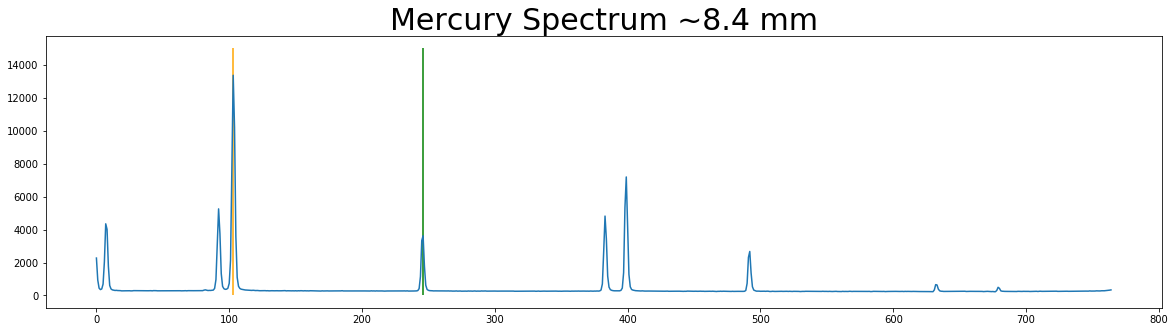

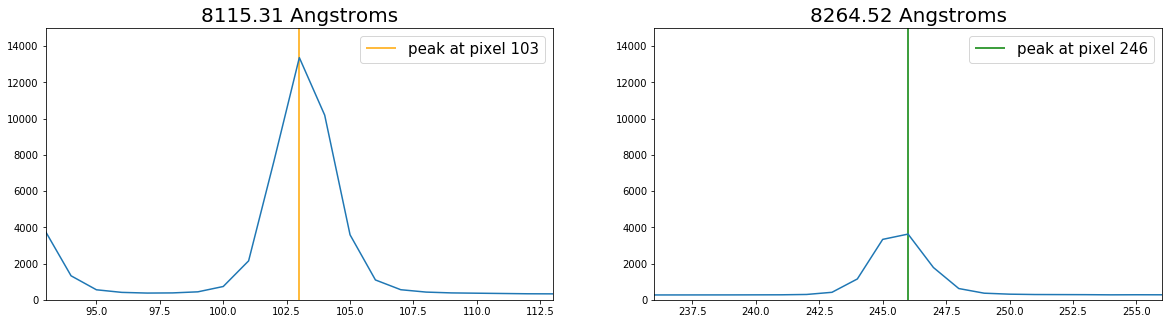

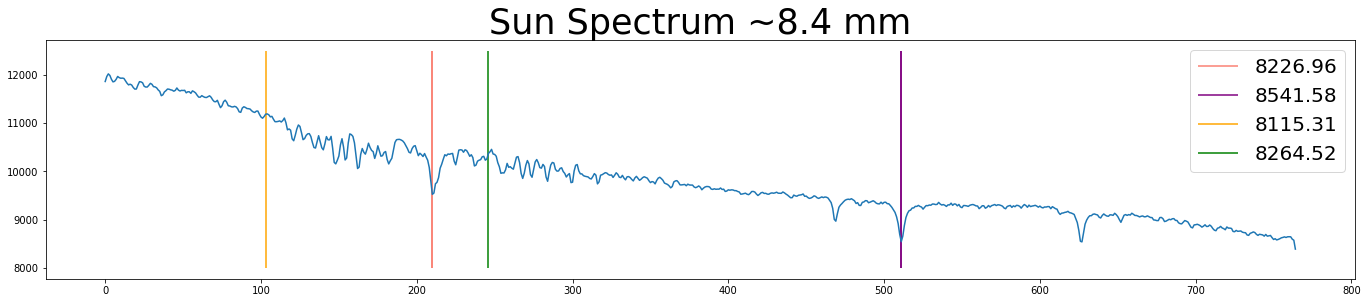

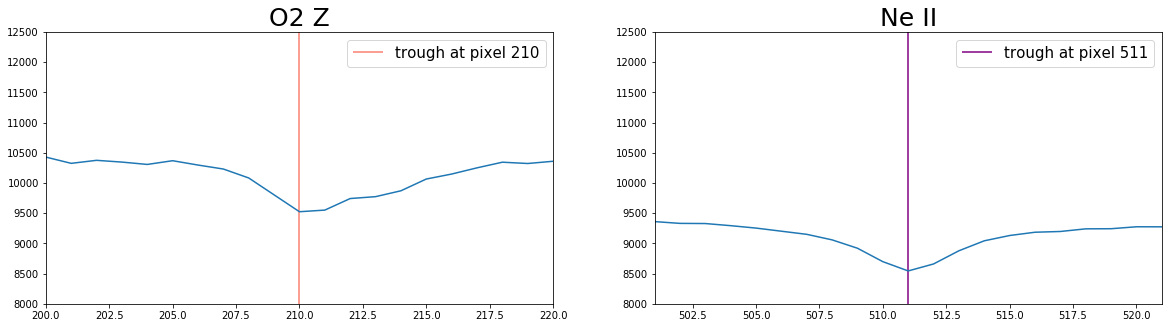

In [63]:
print_plot(df8, "~8.4", data1, p1, p2, y_min, height, l1, l2, data2, psun1, psun2, sun_min,
               sun_max, lam1,lam2)

In [64]:
df_all = pd.concat([df, df2b, df3, df4, df5, df6, df7, df8])
display(df_all)

df_final = pd.concat([df, df3, df2a, df4, df5, df6, df7, df8])


Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Ca K            4.0              3934.108108                    3933.66   
Ca H            4.0              3969.462703                    3968.47   
Na D1           4.4              4317.596907                    5889.95   
Na D2           4.4              4322.952577                    5895.92   
Hβ F            4.8              4860.602421                    4861.34   
Mg b            4.8              5183.807737                    5183.60   
Hα C            5.2              6563.544093                    6562.81   
O2 B            5.2              6867.331865                    6867.19   
O2 B            5.6              6868.558050                    6867.19   
O2 A            5.6              7595.097673                    7593.70   
O2 A            6.0              7593.113200                    7593.70   
Ne II           6.0              7604.662320                    7604.63   
Fe I            6.4              8045.062402                    8046.05   
O2 Z            6.4              8228.020699                    8226.96   
O2 Z            6.8              8226.956643                    8226.96   
Ne II           6.8              8541.028042                    8541.58   

         Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Ca K      0.448108   0.011392         138.245523          0.114149  
Ca H      0.992703   0.025015         138.245523          0.114149  
Na D1 -1572.353093 -26.695525         137.923264          0.134450  
Na D2 -1572.967423 -26.678914         137.923264          0.134450  
Hβ F     -0.737579  -0.015172         138.295174          0.144907  
Mg b      0.207737   0.004008         138.295174          0.144907  
Hα C      0.734093   0.011186         138.278426          0.208252  
O2 B      0.141865   0.002066         138.278426          0.208252  
O2 B      1.368050   0.019922         138.160522          0.220294  
O2 A      1.397673   0.018406         138.160522          0.220294  
O2 A     -0.586800  -0.007727         138.175498          0.232362  
Ne II     0.032320   0.000425         138.175498          0.232362  
Fe I     -0.987598  -0.012274         137.964003          0.244348  
O2 Z      1.060699   0.012893         137.964003          0.244348  
O2 Z     -0.003357  -0.000041         138.200014          0.256522  
Ne II    -0.551958  -0.006462         138.200014          0.256522

In [65]:
df_final['Microm. (mm)'] = ["4.0", "4.0", "4.8", "4.8","~6.0", "~6.0", "~6.8", "~6.8", "~7.2", "~7.2", "~7.6", "~7.6", "~8.0",
                      "~8.0", "~8.4", "~8.4"]

In [66]:
display(df_final)

Microm. (mm)  Measured Wavelength (Å)  Literature Wavelength (Å)  \
Ca K           4.0              3934.108108                    3933.66   
Ca H           4.0              3969.462703                    3968.47   
Hβ F           4.8              4860.602421                    4861.34   
Mg b           4.8              5183.807737                    5183.60   
Na D1         ~6.0              5890.596907                    5889.95   
Na D2         ~6.0              5895.952577                    5895.92   
Hα C          ~6.8              6563.544093                    6562.81   
O2 B          ~6.8              6867.331865                    6867.19   
O2 B          ~7.2              6868.558050                    6867.19   
O2 A          ~7.2              7595.097673                    7593.70   
O2 A          ~7.6              7593.113200                    7593.70   
Ne II         ~7.6              7604.662320                    7604.63   
Fe I          ~8.0              8045.062402                    8046.05   
O2 Z          ~8.0              8228.020699                    8226.96   
O2 Z          ~8.4              8226.956643                    8226.96   
Ne II         ~8.4              8541.028042                    8541.58   

       Error (Å)  Error (%)  Focal Length (mm)  Inc. Angle (rad)  
Ca K    0.448108   0.011392         138.245523          0.114149  
Ca H    0.992703   0.025015         138.245523          0.114149  
Hβ F   -0.737579  -0.015172         138.295174          0.144907  
Mg b    0.207737   0.004008         138.295174          0.144907  
Na D1   0.646907   0.010983         137.923264          0.134450  
Na D2   0.032577   0.000553         137.923264          0.134450  
Hα C    0.734093   0.011186         138.278426          0.208252  
O2 B    0.141865   0.002066         138.278426          0.208252  
O2 B    1.368050   0.019922         138.160522          0.220294  
O2 A    1.397673   0.018406         138.160522          0.220294  
O2 A   -0.586800  -0.007727         138.175498          0.232362  
Ne II   0.032320   0.000425         138.175498          0.232362  
Fe I   -0.987598  -0.012274         137.964003          0.244348  
O2 Z    1.060699   0.012893         137.964003          0.244348  
O2 Z   -0.003357  -0.000041         138.200014          0.256522  
Ne II  -0.551958  -0.006462         138.200014          0.256522

Text(0.5, 0.98, 'Mercury Spectra 5.2')

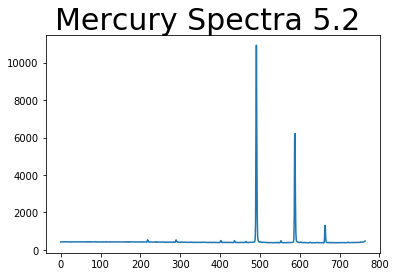

In [67]:
plt.plot(Hg_spectra[3])
plt.suptitle("Mercury Spectra 5.2", fontsize=30)